```
import Pyro4.util
try:
    [run your usual rfsoc experiment here]
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))
```

In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq
import Pyro4.util

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported experiments.

In [4]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [34]:
expt_path=os.path.join(os.getcwd(), 'data', 'data_240218')
# expt_path = 'C:\_Data\LLqub'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_240218


In [7]:
config_file = 'config_q3diamond_full688and638_reset.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_zcu216.yml'
# config_file = 'config_zcu216_LLStdCandle.yml'
config_path = os.path.join(os.getcwd(), config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and638_reset.yml


# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [8]:
import yaml
print('Using config file', config_file)
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

Using config file config_q3diamond_full688and638_reset.yml


In [9]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium
print(im.keys())

dict_keys(['Pyro.NameServer', 'Qick187', 'SC_26C1', 'scqubA', 'scredA', 'scqubB', 'scredB', 'readoutattengrbA', 'readoutattengrbB', 'BNCfungen', 'YOKO4', 'Qick60', 'eHe_4x2_rfsoc', 'YOKO1'])


In [10]:
lo1 = im[yaml_cfg.aliases.readout_LO]
# lo1 = SignalCore(name="SignalCore", address='10003494')
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print(f'set freq to [MHz] {lo_freq*1e-6}')
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to [MHz] 5925.0
set power to 15.0


In [11]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Software version: 0.2.207
	Firmware timestamp: Mon Jul 24 13:57:32 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC ti

# Qubit/resonator to probe

In [350]:
qubit_i = 1
print(qubit_i)

1


# RFSoC Calibration

In [67]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=1.0, # [us]
    readout_length=1.5, # [us]
    trig_offset=0, # [clock ticks]
    gain=1.0,
    # gain=30000, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i]-15, # [MHz]
    reps=1000, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]
print(tof.cfg)

import Pyro4.util
try:
    tof.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, -1, 1, 1], 'frequency': [-67.56914314909822, -818.3632498995282, 824.7980472489251, 92.93933333000001], 'gain': [0.07, 0.05, 0.2, 0.2], 'readout_length': [7.0, 5.0, 8.0, 3.0], 'relax_delay': 0.1}, 'qubit': {'f_ge': [4117.588085240945, 3449.8814354444544, 4766.879640809914, 4382.913995152254], 'f_ef': [3892.0085605773347, 3349.9263006886017, 4577.143752025944, 4210.296530482046], 'f_Q1_ZZ': [3448.1738335109158, 0, 3452.3213430710007, 3452.1109809499007], 'f_Q_ZZ1': [4110.747000365902, 0, 4765.913708870817, 4384.902653256242], 'f_EgGf': [2686.53594683, -1, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [-1, -1, 5885.4896, 5148.7667], 'f_f0g1': [0, 1006.52, 0, 0], 'gs': [52.780871281379206, 51.02304946445798, 42.53417522582186, 3.6894442976609656, 2.646475637985887, 6.67458308496662], 'ZZs': [0.0, -5.271130541643743, -0.09970310829339724, -0.539307331083819, -5.271130541643743, 0.0, -0.9894168497467035, -1.2726243213960515, -0.099

  0%|          | 0/1000 [00:00<?, ?it/s]

In [68]:
print('qubit_i', qubit_i)
tof.display(adc_trig_offset=135)

qubit_i 3


In [45]:
tof.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00000_adc_trig_offset_calibration_qubit2.h5


In [346]:
print('g/delta 01', t2EFr.cfg.device.qubit.gs[0]/(t2EFr.cfg.device.qubit.f_ge[0]-t2EFr.cfg.device.qubit.f_ge[1]))
print('g/delta 12', t2EFr.cfg.device.qubit.gs[1]/(t2EFr.cfg.device.qubit.f_ge[1]-t2EFr.cfg.device.qubit.f_ge[2]))
print('g/delta 13', t2EFr.cfg.device.qubit.gs[2]/(t2EFr.cfg.device.qubit.f_ge[1]-t2EFr.cfg.device.qubit.f_ge[3]))
print('\n')
print('g/delta 02', t2EFr.cfg.device.qubit.gs[3]/(t2EFr.cfg.device.qubit.f_ge[0]-t2EFr.cfg.device.qubit.f_ge[2]))
print('g/delta 03', t2EFr.cfg.device.qubit.gs[4]/(t2EFr.cfg.device.qubit.f_ge[0]-t2EFr.cfg.device.qubit.f_ge[3]))
print('g/delta 23', t2EFr.cfg.device.qubit.gs[5]/(t2EFr.cfg.device.qubit.f_ge[2]-t2EFr.cfg.device.qubit.f_ge[3]))

g/delta 01 0.08120922261790635
g/delta 12 -0.04315413958376367
g/delta 13 -0.04587588018025745


g/delta 02 -0.0049733917280618215
g/delta 03 -0.006406816426247864
g/delta 23 0.014048497150660918


# Resonator spectroscopy

## Single tone (resonator) spectroscopy

Measures the resonant frequency of the readout resonator when the qubit is in its ground state: sweep readout pulse frequency and look for the frequency with the maximum measured amplitude.

The resonator frequency should be stored in the parameter <code>cfg.device.readouti.frequency</code>.

Note that harmonics of the clock frequency (6144 MHz) will show up as "infinitely"  narrow peaks!


In [231]:
qubit_i = 1

In [234]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 2.0 # MHz
npts = 150
rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.75*span, # resonator frequency to be mixed up [MHz]
    # start=-807-span/2, # resonator frequency to be mixed up [MHz]
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.75*span,
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.25*span,
    # start=-850,
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number experiments stepping from start
    reps=1000, # Number averages per point
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)

rspec.cfg.device.readout.gain[qubit_i] = 0.08
# rspec.cfg.device.readout.frequency[qubit_i] = 822.2138666666668
# rspec.cfg.device.readout.readout_length = 2.5

if rspec.cfg.expt.pulse_e: rspec.cfg.device.readout.relax_delay = 500 # Wait time between experiments [us]
else: rspec.cfg.device.readout.relax_delay = 20 # Wait time between experiments [us]

print(rspec.cfg)
rspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, -1, 1, 1], 'frequency': [-67.50045636884761, -818.2965832328615, 824.9447139155917, 93.39933333000003], 'gain': [0.1, 0.08, 0.4, 0.25], 'readout_length': [7.0, 5.0, 8.0, 7.0], 'relax_delay': 20}, 'qubit': {'f_ge': [4117.686452385398, 3445.1572577243646, 4767.054343954413, 4383.523802667161], 'f_ef': [3892.010624623449, 3349.941101774378, 4578.398115858877, 4210.841209697969], 'f_Q1_ZZ': [3445.1572577243646, 0, 3449.311443189216, 3449.1061351754615], 'f_Q_ZZ1': [4112.428960914854, 0, 4765.8670233481, 4382.389648653785], 'f_EgGf': [2686.53594683, -1, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [-1, -1, 5887.833333333333, 5148.666667], 'f_f0g1': [0, 1006.52, 0, 0], 'gs': [54.18305729787911, 56.80877037961852, 42.812523932608954, 3.2287859260584977, 1.7043533039484866, 5.3832463588099975], 'ZZs': [0.0, -5.260905516769526, -0.09988449936008692, -0.41585925233903254, -5.252491785348866, 0.0, -1.0947129169840082, -1.300020930738355

  0%|          | 0/150 [00:00<?, ?it/s]

electrical delay phase correction (no mux support) (deg) -5.213138717915214
[-818.3032498995283, 5000, 1000, 0, 9.574504165479723, 34.55797981228111, 0.2248274918917037]
lo freq 5925.0
mux mixer -950
fit resonator freq -818.3032498995283

Freq with minimum transmission: -818.3632498995282
Freq with maximum transmission: -819.0432498995282
From fit:
	f0: 5793.303249899528
	Qi: 5000
	Qe: 1000
	Q0: 833.3333333333333
	kappa [MHz]: 6.951963899879434
	phi [radians]: 0


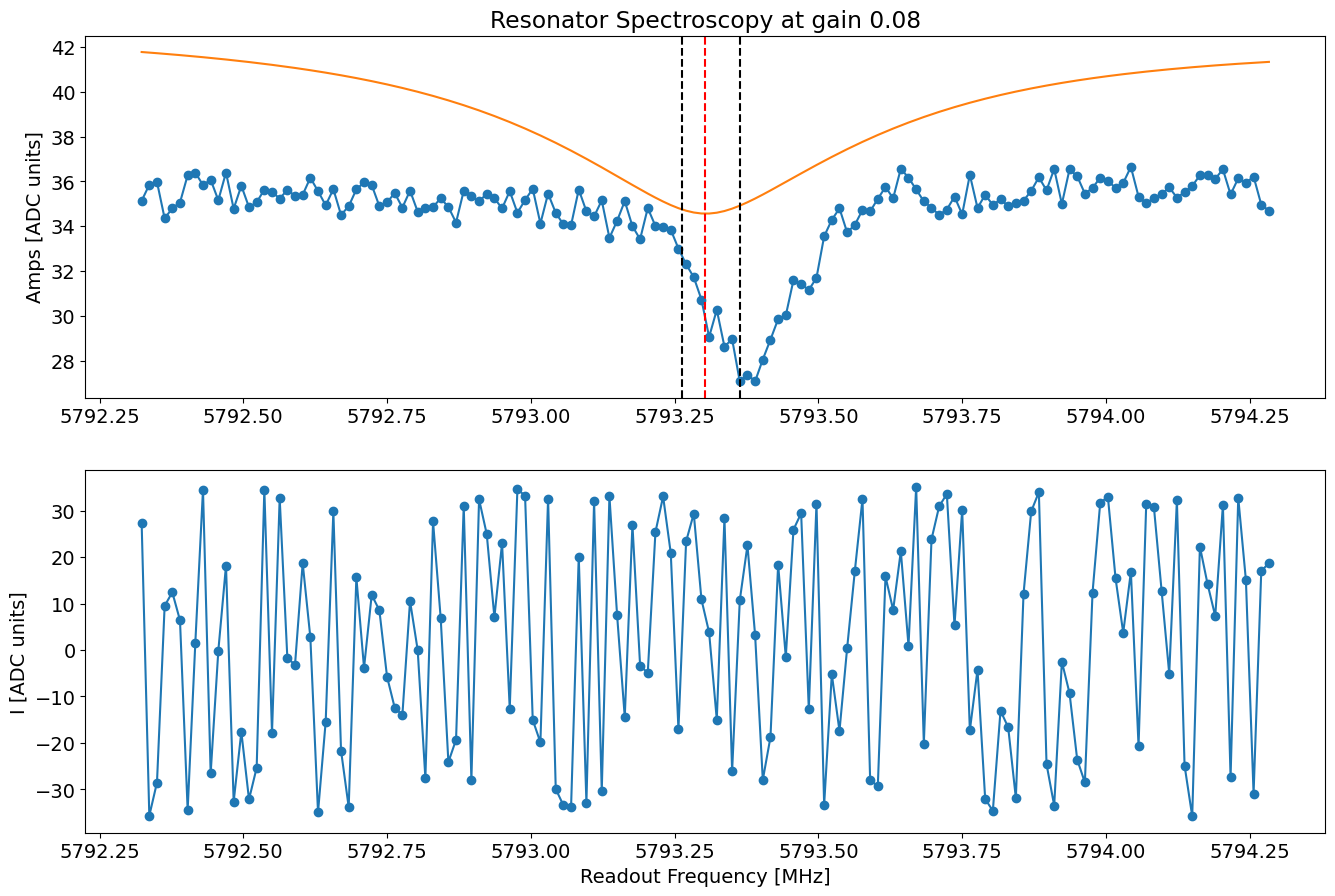

In [235]:
# # TESTING
# rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# # temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit1.h5')
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit0.h5')
# i_gain = np.argmin(np.abs(temp_data['gainpts']-30))
# temp_data['amps'] = temp_data['amps'][i_gain][80:]
# temp_data['xpts'] = temp_data['xpts'][80:]
# data = rspec.analyze(data=temp_data, fit=True)
# rspec.display(data=data, fit=True)

data = rspec.analyze(fit=True, findpeaks=False)
rspec.display(data=data, fit=True, findpeaks=False)

In [ ]:
rspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230927\00000_ResonatorSpectroscopy.h5


Repeat res spec over time

In [236]:
qubit_i = 2

In [237]:
import time

rspecs = []

drift_meas_time = 3*60

start_time = time.time()
elapsed_time = 0
meas_times = []
for i in tqdm(range(100)):
# for i in tqdm(range(3)):
    rspec = meas.ResonatorSpectroscopyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"resonator_spectroscopy_qubit{qubit_i}",
        config_file=config_path,
    )

    span = 0.0 # MHz
    npts = 1
    # arduino.set_voltage(channel=4, voltage=0.0104)
    rspec.cfg.expt = dict(
        start=rspec.cfg.device.readout.frequency[qubit_i], # resonator frequency to be mixed up [MHz]
        step=span/npts, # min step ~1 Hz
        expts=npts, # Number experiments stepping from start
        reps=1000, # Number averages per point
        pulse_e=True, # add ge pi pulse prior to measurement
        pulse_f=False, # add ef pi pulse prior to measurement
        qubit=qubit_i,
    )

    # rspec.cfg.device.readout.gain[qubit_i] = 0.20
    # rspec.cfg.device.readout.frequency[qubit_i] = 824.7980472489251
    # rspec.cfg.device.readout.readout_length = 2.5

    if rspec.cfg.expt.pulse_e: rspec.cfg.device.readout.relax_delay = 500 # Wait time between experiments [us]
    else: rspec.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

    # print(rspec.cfg)
    rspec.go(analyze=False, display=False, progress=False, save=False)
    rspecs.append(rspec)


    meas_times.append(elapsed_time)
    if elapsed_time > drift_meas_time: break
    # time.sleep(30)

100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


In [238]:
amp_freq = []
for rspec in rspecs:
    xpts = rspec.data['xpts']
    freq_loc = np.argmin(np.abs(xpts-rspec.cfg.device.readout.frequency[qubit_i]))
    amp_freq.append(rspec.data['amps'][freq_loc])
    # data = rspec.analyze(fit=True, findpeaks=False)
    # rspec.display(data=data, fit=False, findpeaks=False)
plt.plot(amp_freq)
plt.ylabel('Amplitude at measurement frequency')
plt.xlabel('Iteration')
plt.title(f'Readout Amplitude of Q{qubit_i} in e (readout gain {rspec.cfg.device.readout.gain[qubit_i]})')
plt.show()

## Power sweep resonator spectroscopy

Repeat resonator spectroscopy at a range of powers to check that resonator frequency shifts at low powers. (Check qubit is alive.)

Use this experiment to determine the appropriate resonator gain, which should be stored in <code>cfg.device.readout.gain</code>


In [197]:
qubit_i = 3

In [198]:
rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"power_sweep_resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 1.0
npts_f = 100

span_gain = 0.8
npts_gain = 20

rpowspec.cfg.expt = dict(
    # start_f=rpowspec.cfg.device.readout.frequency[qubit_i]+span_f*0.9, # sweep frequency [MHz]
    start_f=rpowspec.cfg.device.readout.frequency[qubit_i]-span_f*0.5, # sweep frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=rpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    # start_gain=0.001,
    start_gain=0.01,
    step_gain=span_gain/npts_gain, # Gain step size
    # step_gain=0, # Gain step size
    expts_gain=npts_gain+1, # Number experiments stepping gain from start
    reps=1000, # Number averages per point
    pulse_e=False, # add ge pi pulse before measurement
    pulse_f=False, # add ef pi pulse before measurement
    qubit=qubit_i,
)
rpowspec.cfg.device.readout.relax_delay = 25 # Wait time between experiments [us]
# rpowspec.cfg.device.readout.readout_length = 3

print(rpowspec.cfg)

rpowspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, -1, 1, 1], 'frequency': [-67.56914314909822, -818.2965832328615, 824.9447139155917, 93.39933333000003], 'gain': [0.16, 0.15, 0.4, 0.15], 'readout_length': [7.0, 5.0, 8.0, 7.0], 'relax_delay': 25}, 'qubit': {'f_ge': [4117.686452385398, 3450.4061561062, 4767.054343954413, 4383.523802667161], 'f_ef': [3892.010624623449, 3349.941101774378, 4578.398115858877, 4210.841209697969], 'f_Q1_ZZ': [3445.1572577243646, 0, 3449.311443189216, 3449.1061351754615], 'f_Q_ZZ1': [4112.428960914854, 0, 4765.8670233481, 4382.389648653785], 'f_EgGf': [2686.53594683, -1, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [-1, -1, 5887.833333333333, 5148.666667], 'f_f0g1': [0, 1006.52, 0, 0], 'gs': [54.18305729787911, 56.80877037961852, 42.812523932608954, 3.2287859260584977, 1.7043533039484866, 5.3832463588099975], 'ZZs': [0.0, -5.260905516769526, -0.09988449936008692, -0.41585925233903254, -5.252491785348866, 0.0, -1.0947129169840082, -1.3000209307383557,

  0%|          | 0/21 [00:00<?, ?it/s]

qubit 3


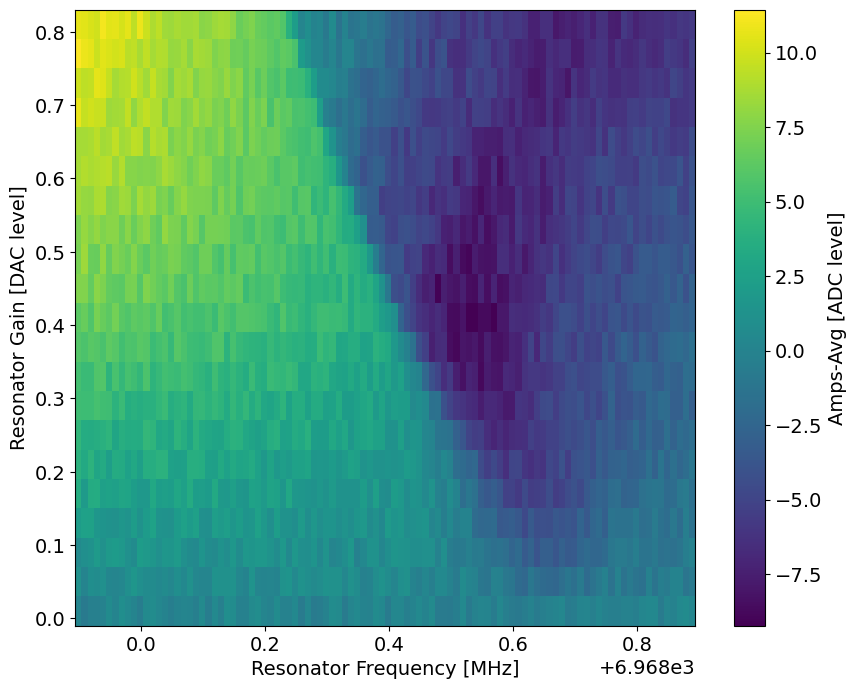

plotting at gain 0.29000000000000004 index 7


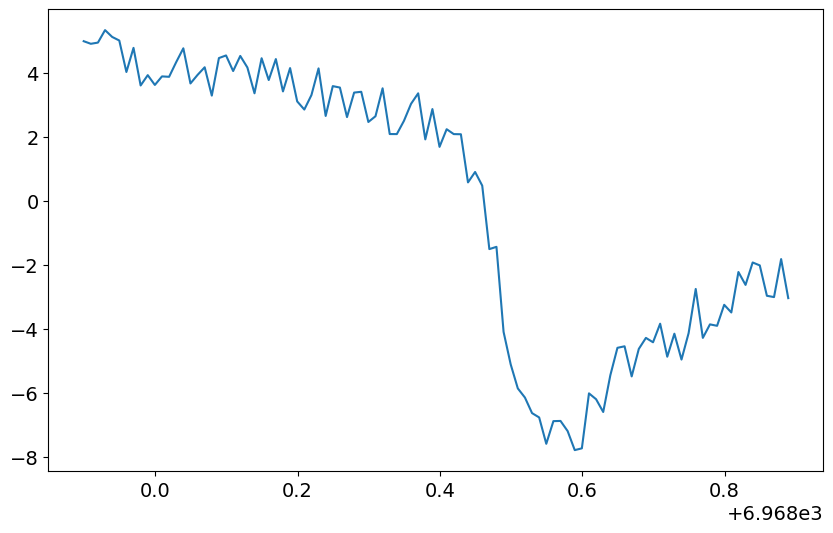

In [204]:
# # TESTING
# rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit1.h5')
# rpowspec.display(data=temp_data, fit=False)

print('qubit', rpowspec.cfg.expt.qubit)
rpowspec.analyze(fit=False, lowgain=None, highgain=None)
rpowspec.display(fit=False, select=0.30)

In [202]:
rpowspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00000_power_sweep_resonator_spectroscopy_qubit3.h5


# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

Measures the qubit frequency f_ge by driving at resonator frequency and sweeping qubit frequency.

Qubit frequency should be stored in <code>cfg.qubiti.f_ge</code>.

In [31]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

# span = 2.5
# npts = 400

span = 150
npts = 300

qspec.cfg.expt = dict(
    start=qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    # start=qspec.cfg.device.qubit.f_ge[qubit_i]-0.95*span, # [MHz]
    # start=4780,
    step=span/npts, # min step ~1 MHz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=40, # Number of start to finish sweeps to average over
    # length=1, # Qubit probe constant pulse length [us]
    # gain=200, # Qubit pulse gain
    length=0.010*100, # Qubit probe constant pulse length [us]
    gain=int(28147/5), # Qubit pulse gain
    # gain=int(3869/150), # Qubit pulse gain
    # pulse_type='const',
    pulse_type='gauss',
    qubit=qubit_i,
)
# qspec.cfg.device.readout.relax_delay = 150 # Wait time between experiments [us]
qspec.cfg.device.readout.relax_delay = 20 # Wait time between experiments [us]
# qspec.cfg.device.readout.frequency[qubit_i] = -813.508 # Wait time between experiments [us]
# qspec.cfg.device.readout.gain[qubit_i] = 0.01
# qspec.cfg.device.readout.readout_length[qubit_i] = 6.0

print(qspec.cfg)

qspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, -1, 1, 1], 'frequency': [-67.62918182586353, -817.8855229899999, 824.8527139155917, 92.93933333000001], 'gain': [0.1, 0.14, 0.2, 0.2], 'readout_length': [3.0, 3.5, 3.5, 3.0], 'relax_delay': 20}, 'qubit': {'f_ge': [4099.431531282737, 3450.2118220025054, 4765.554404281526, 4382.913995152254], 'f_ef': [3889.952046180199, 3349.730554526796, 4575.88394289626, 4210.296530482046], 'f_Q1_ZZ': [3448.1738335109158, 0, 3452.3213430710007, 3452.1109809499007], 'f_Q_ZZ1': [4110.747000365902, 0, 4765.913708870817, 4384.902653256242], 'f_EgGf': [2686.53594683, -1, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [-1, -1, 5885.4896, 5148.7667], 'f_f0g1': [0, 1006.52, 0, 0], 'gs': [52.780871281379206, 51.02304946445798, 42.53417522582186, 3.6894442976609656, 2.646475637985887, 6.67458308496662], 'ZZs': [0.0, -5.271130541643743, -0.09970310829339724, -0.539307331083819, -5.271130541643743, 0.0, -0.9894168497467035, -1.2726243213960515, -0.09970310

  0%|          | 0/40 [00:00<?, ?it/s]

In [32]:
# # TESTING
# qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit1.h5')
# temp_data['avgi'] = temp_data['amps']
# data = qspec.analyze(data=temp_data, fit=True)
# qspec.display(data=data, fit=True)

qspec.analyze(fit=True, signs=[1, -1, 1])
qspec.display(fit=True, signs=[1, -1, 1])

Found peak in amps at [MHz] 4117.628775089551, HWHM -0.6455776521453371
Found peak in I at [MHz] 4117.712952956885, HWHM -0.5039574173744795
Found peak in Q at [MHz] 4117.465882441016, HWHM 0.8836000975280878


In [68]:
qspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240131\00000_qubit_spectroscopy_qubit3.h5


## Length Rabi

Measures Rabi oscillations by sweeping over the duration of the qubit drive pulse. This is a preliminary measurement to prove that we see Rabi oscillations. This measurement is followed up by the Amplitude Rabi experiment below.


In [87]:
soc.cycles2us(1, gen_ch=0)

0.0023251488095238095

In [62]:
lengthrabi = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_qubit{qubit_i}",
    config_file=config_path,
)

lengthrabi.cfg.expt = dict(
    start=soc.cycles2us(1), # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=51,
    reps=2000,
    # gain=10000, # qubit gain [DAC units],
    gain=lengthrabi.cfg.device.qubit.pulses.pi_ge.gain[qubit_i],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
    # qubits=[3,1],
)
# lengthrabi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(lengthrabi.cfg)
# lengthrabi.im[lengthrabi.cfg.aliases.soc].reset()
import Pyro4.util
try:
    lengthrabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [45, 127, 55, 50], 'f_ge': [4128.575129385544, 3457.338723559245, 4782.994651953712, 4396.915066710553], 'f_Q1_ZZ': [3452.057926470567, 0, 3456.1893267454375, 3456.018803727748], 'f_ef': [3902.5097729724093, 3356.650995689788, 4588.124531178372, 4223.758894341571], 'f_EgGf': [2681.44696031, -1, 2022.3, 2407.9], 'f_EgGf_Q': [-1, -1, 5933, 5176], 'gs': [54.34474556, 56.18845266, 43.07411448, 5.80677427, 2.37708297, 6.56997134], 'ZZs': [0.0, -5.222654425229848, -0.12783671475153824, -0.5018857089899029, -5.172752578477684, 0.0, -1.0684162296902286, -1.2142038280621819, -0.23354269077572098, -1.1405468087750705, 0.0, -0.5392270363518037, -0.5256359464065099, -1.2142038280621819, -0.5392270363518037, 0.0], 'pulses': {'pi_ge': {'gain': [29539, 824, 25040, 29830], 'sigma': [0.015, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_ge_IQ': {'gain': 1373}, 'pi_ef': {'gain': [25302, 336, 18042, 19207], 'sigma': [0.015, 0.02101, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'

  0%|          | 0/51 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 189.2352, which is out of bounds 0.8777142857142858 to 131.65714285714284. Instead init to 66.26742857142857
Decay from avgi [us] 0.03417968750000001
Pi length from avgi data [us]: 0.004309656387523624
	Pi/2 length from avgi data [us]: 0.002154828193761812

Decay from avgq [us] 0.2986262395253816
Pi length from avgq data [us]: 0.016862633082525478
Pi/2 length from avgq data [us]: 0.008431316541262739


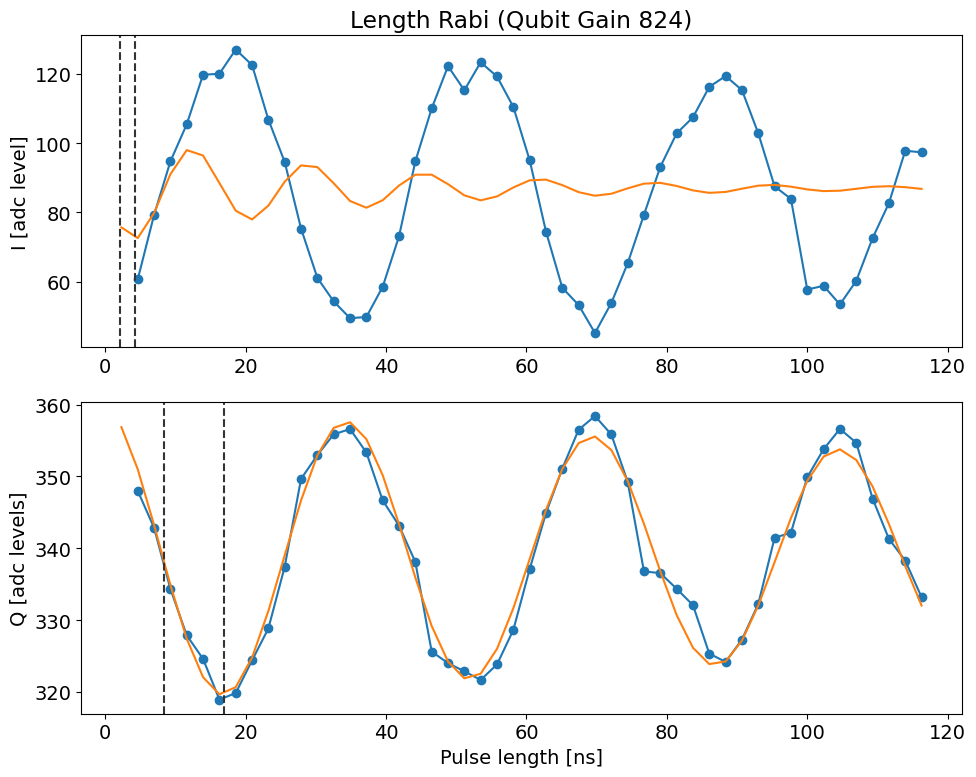

In [63]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

lengthrabi.analyze(fit=True)
lengthrabi.display(fit=True)

In [141]:
lengthrabi.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00001_length_rabi_qubit3.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_221215\\00001_length_rabi_qubit3.h5'

## Amplitude Rabi

Measures Rabi oscillations by sweeping over the amplitude of the qubit drive pulse, which is a Gaussian pulse with sigma set by <code>cfg.device.qubiti.pulses.pi_ge.sigma</code>. We measure the $\pi$ pulse amplitude which are used in subsequent experiments to control the qubit, which should be stored in <code>cfg.device.qubiti.pulses.pi_ge.gain</code>.

QCTRL

In [ ]:
from qctrl import Qctrl
qctrl = Qctrl()

Q-CTRL package update available.

Your version is 22.1.0. Latest version is 22.2.0.

Visit ]8;id=139358;https://boulder.q-ctrl.com/changelog\boulder.q-ctrl.com/changelog]8;;\ for the latest product updates.

In [173]:
# ctrl_result = qctrl.get_result(action_id=1761100)
# ctrl_result = qctrl.get_result(action_id=1763052)
# ctrl_result = qctrl.get_result(action_id=1763052)
ctrl_result = qctrl.get_result(action_id=1764628)

  0%|          | 0/100 [00:00<?, ?it/s]

Fidelity: 0.9807641749181643


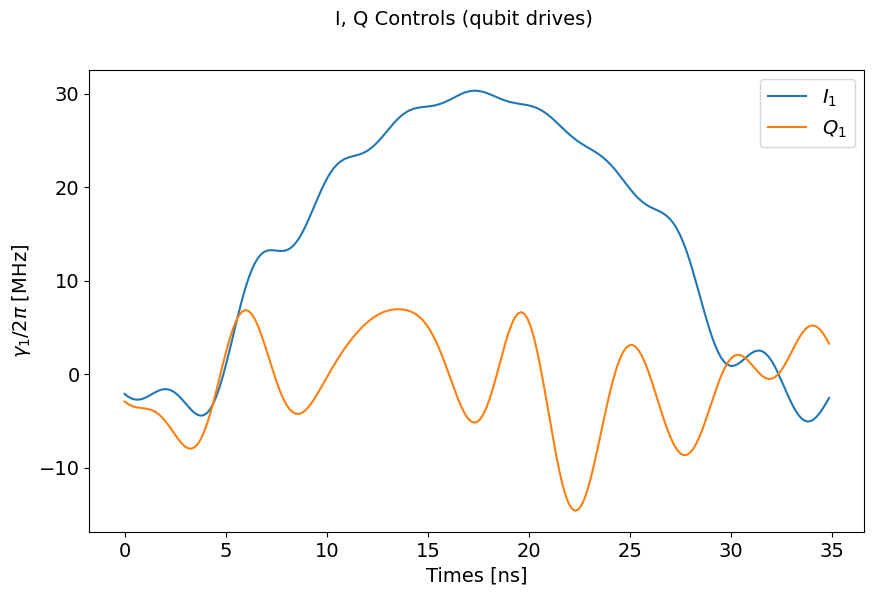

max amplitude (MHz) 33.35044550240938


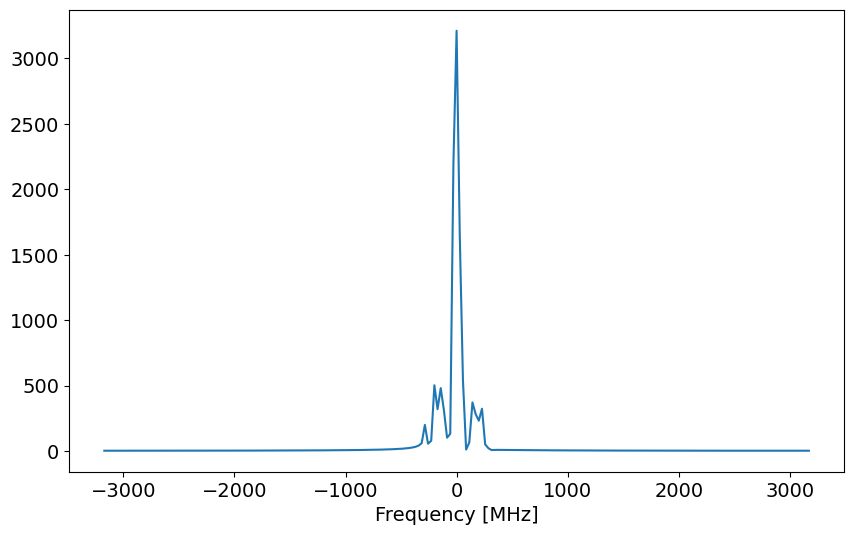

In [175]:
print("Fidelity:", 1-ctrl_result.output["cost"]["value"])

times_us = []
I_values_MHz = []
Q_values_MHz = []
for q in range(4):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    I_values_q = []
    Q_values_q = []
    t = 0
    for j in range(2): # I, Q
        name = f"$\gamma{'I' if j==0 else 'Q'}_{q}$"
        control = ctrl_result.output[name]
        for step, pulse in enumerate(control):
            if q==1 and j==0: times_us.append(t)
            t += pulse['duration']
            # factor of 1/2, -1, and 2pi due to how their controls are defined relative to ours
            if j==0: I_values_q.append(pulse['value'])
            else: Q_values_q.append(pulse['value'])
            # if j==0: I_values_q.append(0.01)
            # else: Q_values_q.append(0.01)

    I_values_MHz.append(I_values_q)
    Q_values_MHz.append(Q_values_q)

times_us = np.array(times_us)*1e-3
I_values_MHz = np.array(I_values_MHz)*1e3
Q_values_MHz = np.array(Q_values_MHz)*1e3

# plt.figure(figsize=(6,8))
plt.suptitle('I, Q Controls (qubit drives)', fontsize=14)
ymax = 1.1*max(abs(np.concatenate((I_values_MHz.flatten(), Q_values_MHz.flatten()))))

# I_values_MHz[0] = 50*np.exp(-(1e3*times_us-150)**2/10**2)
# Q_values_MHz[0] = 0*np.exp(-(times_us)**2/10**2)

controls_index = 0
for q in range(4):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    # plt.subplot(int(f'41{q+1}'))
    plt.plot(1e3*times_us, I_values_MHz[controls_index], label=f'$I_{q}$')
    plt.plot(1e3*times_us, Q_values_MHz[controls_index], label=f'$Q_{q}$')
    # plt.ylim(-ymax, ymax)
    plt.ylabel(f'$\gamma_{q}/2\pi$ [MHz]')
    plt.legend()
    controls_index += 1

plt.xlabel('Times [ns]')
# plt.tight_layout()
plt.show()
print('max amplitude (MHz)', ymax)

fourier = np.fft.fftshift(np.abs(np.fft.fft(I_values_MHz[0] + 1j*Q_values_MHz[0])))
freqs = np.fft.fftshift(np.fft.fftfreq(len(fourier), d=(times_us[1]-times_us[0])))
plt.plot(freqs, fourier)
plt.xlabel('Frequency [MHz]')
# plt.xlim(-200, 200)
plt.show()

In [176]:
"""
Get effective drive rate in units of 1/[sigma] from a Rabi experiment
"""
sigma_n = 4 # total number of sigmas in gaussian
def amp_eff(sigma, sigma_n=sigma_n):
    return 1/2 / (sigma * np.sqrt(2*np.pi) * sp.special.erf(sigma_n/2 / np.sqrt(2)))

# What sigma is needed to get given drive rate?
def sigma_needed(amp_rate, sigma_n=sigma_n):
    return 1 / (2*amp_rate*np.sqrt(2*np.pi)*sp.special.erf(sigma_n/2 / np.sqrt(2)))

ymax/amp_eff(yaml_cfg.device.qubit.pulses.pi_ge.sigma[1])*yaml_cfg.device.qubit.pulses.pi_ge.gain[1]
# amp_eff(50/4)

2082.865072825203

[ 0.          0.06306306  0.12612613  0.18918919  0.25225225  0.31531532
  0.37837838  0.44144144  0.5045045   0.56756757  0.63063063  0.69369369
  0.75675676  0.81981982  0.88288288  0.94594595  1.00900901  1.07207207
  1.13513514  1.1981982   1.26126126  1.32432432  1.38738739  1.45045045
  1.51351351  1.57657658  1.63963964  1.7027027   1.76576577  1.82882883
  1.89189189  1.95495495  2.01801802  2.08108108  2.14414414  2.20720721
  2.27027027  2.33333333  2.3963964   2.45945946  2.52252252  2.58558559
  2.64864865  2.71171171  2.77477477  2.83783784  2.9009009   2.96396396
  3.02702703  3.09009009  3.15315315  3.21621622  3.27927928  3.34234234
  3.40540541  3.46846847  3.53153153  3.59459459  3.65765766  3.72072072
  3.78378378  3.84684685  3.90990991  3.97297297  4.03603604  4.0990991
  4.16216216  4.22522523  4.28828829  4.35135135  4.41441441  4.47747748
  4.54054054  4.6036036   4.66666667  4.72972973  4.79279279  4.85585586
  4.91891892  4.98198198  5.04504505  5.10810811  5.

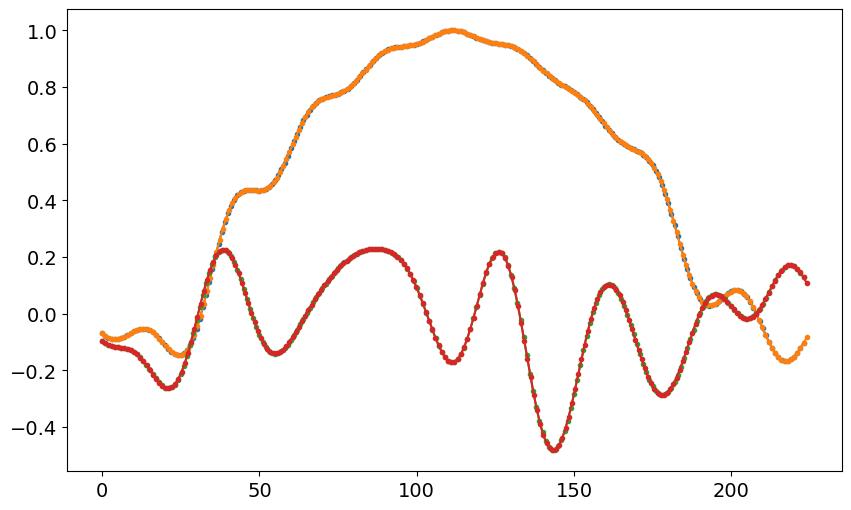

In [177]:
ch = 1
I_mhz_vs_us = I_values_MHz[0]
Q_mhz_vs_us = Q_values_MHz[0]
gencfg = soc['gens'][ch]
maxv = gencfg['maxv']*gencfg['maxv_scale']
samps_per_clk = gencfg['samps_per_clk']
times_cycles = np.linspace(0, soc.us2cycles(times_us[-1], gen_ch=ch), len(times_us))
times_samps = samps_per_clk * times_cycles
print(times_cycles)
print('samps per clock', samps_per_clk)
IQ_scale = max((np.max(np.abs(I_mhz_vs_us)), np.max(np.abs(Q_mhz_vs_us))))
I_func = sp.interpolate.interp1d(times_samps, I_mhz_vs_us/IQ_scale, kind='quadratic', fill_value='extrapolate')
Q_func = sp.interpolate.interp1d(times_samps, Q_mhz_vs_us/IQ_scale, kind='quadratic', fill_value='extrapolate')
print(times_samps[-1])
t = np.arange(0, np.round(times_samps[-1]))
iamps = I_func(t)
qamps = Q_func(t)
plt.plot(iamps, '.-')
plt.plot(times_samps, I_func(times_samps), '.-')
plt.plot(qamps, '.-')
plt.plot(times_samps, Q_func(times_samps), '.-')
plt.show()

Run amplitude rabi

In [358]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)

span = 4000
# span = 32000
npts = 101
    
amprabi.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=80,
    rounds=10,
    sigma_test=0.250, # gaussian sigma for pulse length - overrides config [us]
    checkZZ=False,
    checkEF=False, 
    # qubits=[0, 1], # qZZ, qTest
    qubits=[qubit_i],
    pulse_type='gauss',
    # n_pulses=10,
    # pulse_type='adiabatic',
    # mu=6, # dimensionless
    # beta=4, # dimensionless
    # sigma_test=0.100, # us
    # pulse_type='pulseiq',
    # Icontrols=I_values_MHz[0],
    # Qcontrols=Q_values_MHz[0],
    # times_us=times_us,
)

# amprabi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(amprabi.cfg)

import Pyro4.util
try:
    amprabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, -1, 1, 1], 'frequency': [-67.5604563688476, -818.3165832328616, 824.8647139155917, 93.52599999666671], 'frequency_ef': [-67.5604563688476, -818.3165832328616, 823.0647139155917, 92.22599999666672], 'gain': [0.16, 0.15, 0.4, 0.25], 'readout_length': [7.0, 5.0, 8.0, 7.0], 'relax_delay': [300, 525, 300, 350]}, 'qubit': {'f_ge': [4117.659535585885, 3450.4562851273354, 4766.871603044884, 4383.681408315995], 'f_ef': [3892.010624623449, 3349.941101774378, 4577.036256658536, 4210.899264670438], 'f_Q1_ZZ': [3445.2023317296585, 0, 3449.311443189216, 3449.1061351754615], 'f_Q_ZZ1': [4112.401046361381, 0, 4765.8670233481, 4382.389648653785], 'f_EgGf': [2686.53594683, 0, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [0, 0, 5890.497375, 5148.666667], 'f_f0g1': [0, 1006.52, 0, 0], 'gs': [54.18305729787911, 56.80877037961852, 42.812523932608954, 3.2287859260584977, 1.7043533039484866, 5.3832463588099975], 'ZZs': [0.0, -5.258489224504046, -0.0

  0%|          | 0/10 [00:00<?, ?it/s]

0.0002564102564102564
Pi gain from amps data [dac units]: 2200
	Pi/2 gain from amps data [dac units]: 1100
Pi gain from avgi data [dac units]: 2181
	Pi/2 gain from avgi data [dac units]: 1090
Pi gain from avgq data [dac units]: 2204
	Pi/2 gain from avgq data [dac units]: 1102


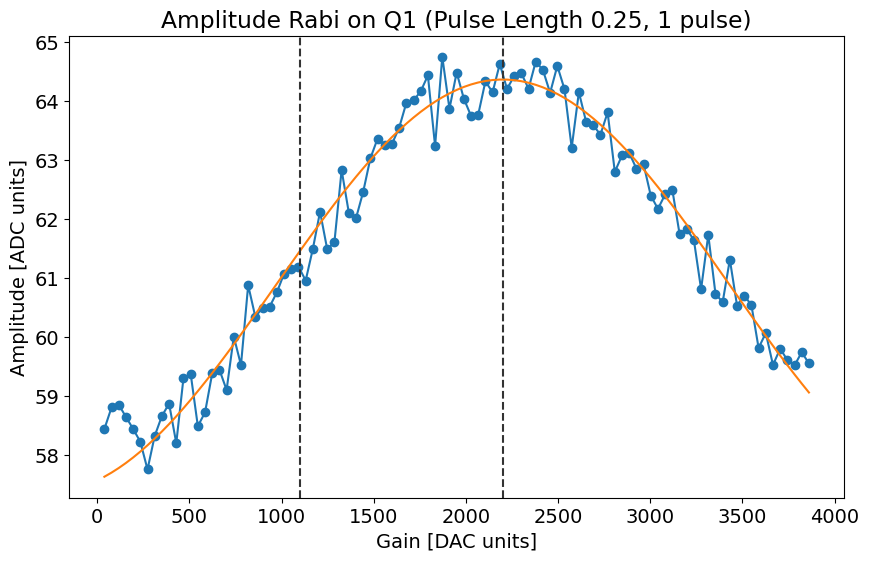

In [359]:
# # TESTING
# amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit2.h5')
# data = amprabi.analyze(data=temp_data, fit=True)
# amprabi.display(data=data, fit=True)

amprabi.analyze(fit=True)
amprabi.display(fit=True)

In [71]:
amprabi.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220801\00000_amp_rabi_qubit1.h5


## Amplitude rabi qubit frequency sweep (chevron)

In [63]:
amprabichev = meas.AmplitudeRabiChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit_chevron{qubit_i}",
    config_file=config_path,
)

# span_gain = 32000
# npts_gain = 51
span_gain = 0
npts_gain = 1

span_f = 50
npts_f = 300

amprabichev.cfg.expt = dict(
    start_f=amprabichev.cfg.device.qubit.f_ge[qubit_i]-span_f/2,
    # start_f=amprabichev.cfg.device.qubit.f_Q1_ZZ[0]-span_f/2,
    # start_f=amprabichev.cfg.device.qubit.f_ef[qubit_i]-span_f/2,
    step_f=span_f/(npts_f-1),
    expts_f=npts_f,
    # start_gain=0, # qubit gain [dac level]
    start_gain=28000,
    step_gain=int(span_gain/npts_gain), # [dac level]
    expts_gain=npts_gain,
    reps=50,
    rounds=10,
    # sigma_test=0.2, # gaussian sigma for pulse length - overrides config [us]
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
    # pulse_type='gauss',
    pulse_type='adiabatic',
    mu=6, # dimensionless
    beta=4, # dimensionless
    sigma_test=0.120*4, # us
)

# amprabichev.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

print(amprabichev.cfg)

amprabichev.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [30, 110, 105, 150], 'f_ge': [4140.530270731964, 3463.742568636059, 4800.079246546452, 4415.18623279066], 'f_Q1_ZZ': [3458.6082793015007, 0, 3462.660233985849, 3462.4180842997853], 'f_ef': [3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869355], 'f_EgGf': [2682.783, 0, 2024.5, 2407.3], 'gs': [54.38663964, 52.60236201, 41.1249601, 6.26475719, 2.73059709, 6.00700312], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [22882, 19375, 8131, 5854], 'sigma': [0.03157, 0.045, 0.07, 0.07043], 'type': 'gauss'}, 'pi_ge_adiabatic': {'gain': [-1, 25000, -1, -1], 'mu': [0, 6, 0, 0], 'beta': [0, 4, 0, 0], 'period': [0, 0.48, 0, 0]}, 'pi_ef': {'gain': [13782, 21716, 23173, 22120], 'sigma': [0.021

  0%|          | 0/300 [00:00<?, ?it/s]

s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\amplitude_rabi.py:472: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(
s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\amplitude_rabi.py:483: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(


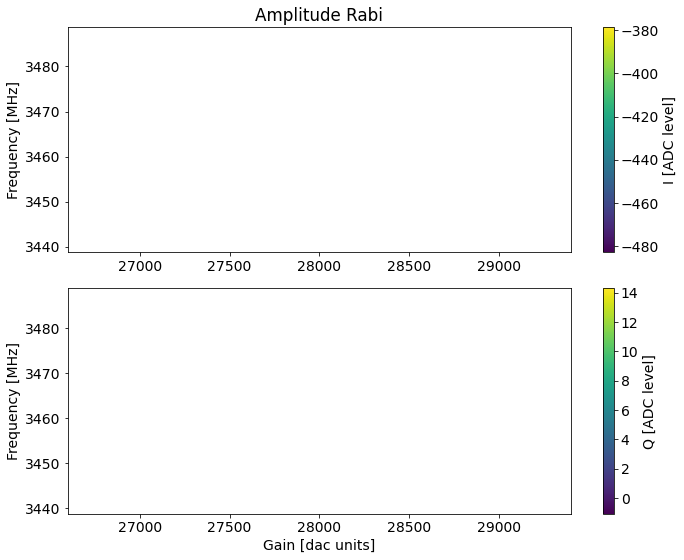

In [65]:
# # TESTING
# temp_data_file = '/home/xilinx/jupyter_notebooks/_experiment/20211215_LL_StandardCandle1/data/00000_power_sweep_resonator_spectroscopy_qubit2.h5'
# with SlabFile(temp_data_file) as a:
#     temp_data = dict(
#         amps=np.asarray(a['amps']),
#         gainpts=np.asarray(a['gain']),
#         fpts=np.asarray(a['freq']),
#     )

# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

amprabichev.analyze()
amprabichev.display()

In [ ]:
amprabichev.save_data()

## Single Shot

Measures the single shot readout fidelity of the system. We acquire single shot (I, Q) readout values by first preparing the qubit in its ground (blue dots) a certain number of times and then preparing the qubit in its excited state (red dots) the same number of times. We then extract two parameters which are used to optimize the associated readout fidelity: the rotation angle of the IQ blobs and the threshold that classifies the two qubit states (ground and excited). The two output parameters should be stored in <code>cfg.device.readouti.phase</code> and <code>cfg.device.readouti.threshold</code>.

Note that this experiment already assumes that you have found your qubit frequency and $\pi$ pulse amplitude. Every time you reset the QICK firmware the single shot angle and threshold changes. So, this experiment is used to calibrate any experiment below that uses single shot data (such as the Active Reset experiment).

In [347]:
qubit_i = 1

In [348]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)

shot.cfg.expt = dict(
    reps=10000,
    check_f=True,
    # qubit=1,
    qubit=qubit_i,
)

# shot.cfg.device.readout.frequency_ef[qubit_i]=shot.cfg.device.readout.frequency_ef[qubit_i] - 1.3
# shot.cfg.device.readout.frequency=shot.cfg.device.readout.frequency_ef
# print(shot.cfg.device.readout.frequency_ef)
# shot.cfg.device.readout.frequency[qubit_i]=shot.cfg.device.readout.frequency[qubit_i] - 0.2
# shot.cfg.device.readout.frequency[qubit_i]=824.8013805822584
# shot.cfg.device.readout.gain[qubit_i]=0.45
# shot.cfg.device.readout.readout_length = 3.5 # [us]
# shot.cfg.device.readout.relax_delay = 500 # Wait time between experiments [us]

shot.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

qubit 1
Unrotated:
Ig 30.016590761223163 +/- 8.835865167808429 	 Qg -50.312296681847755 +/- 9.033371950769746 	 Amp g 58.58603006117599
Ie 25.80871828236825 +/- 8.940111537042327 	 Qe -59.9430709173715 +/- 9.154214412537055 	 Amp e 65.26301931709625
If 26.632400780741705 +/- 8.913196887592925 	 Qf -59.623942745608325 +/- 9.120594595877675 	 Amp f 65.30160273590252
Rotated:
Ig 37.204307851045186 +/- 8.835865167808429 	 Qg 45.50894016535855 +/- 9.033371950769746 	 Amp g 58.78115478322561
Ie 47.429686619676716 +/- 8.940111537042327 	 Qe 44.62394314270594 +/- 9.154214412537055 	 Amp e 65.12197382177688
If 46.829785074688985 +/- 8.913196887592925 	 Qf 45.260697030441065 +/- 9.120594595877675 	 Amp f 65.12725593653505


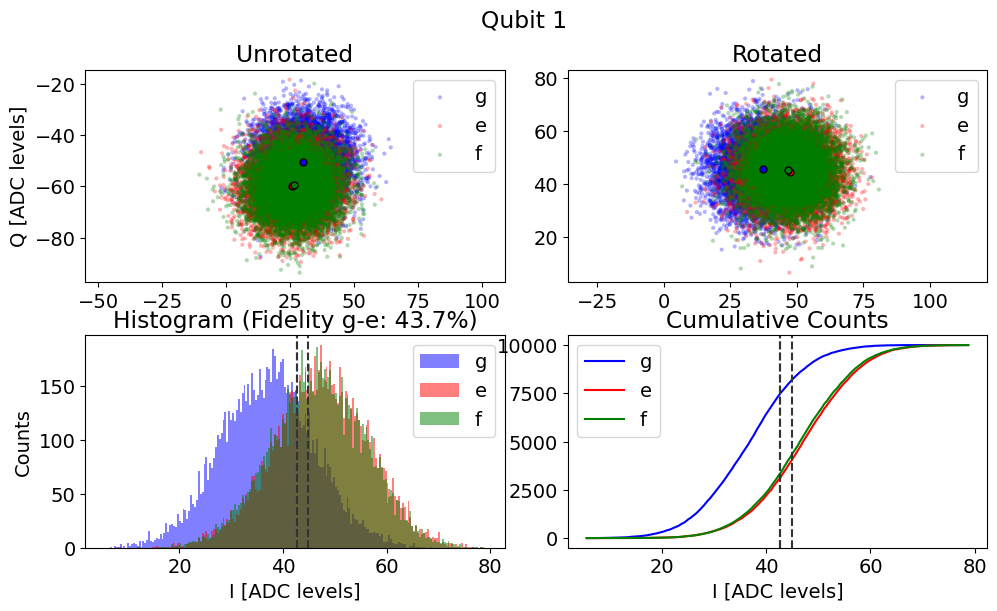

ge fidelity (%): 43.69218460923046
gf fidelity (%): 41.436215432314846
ef fidelity (%): 2.9102910291029103
rotation angle (deg): 109.97298063945141
threshold ge: 42.685277063555425
threshold gf: 42.685277063555425
threshold ef: 44.89495603272226


In [349]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

print('qubit', qubit_i)
shot.analyze(verbose=False)
shot.display(verbose=True, plot_f=False)

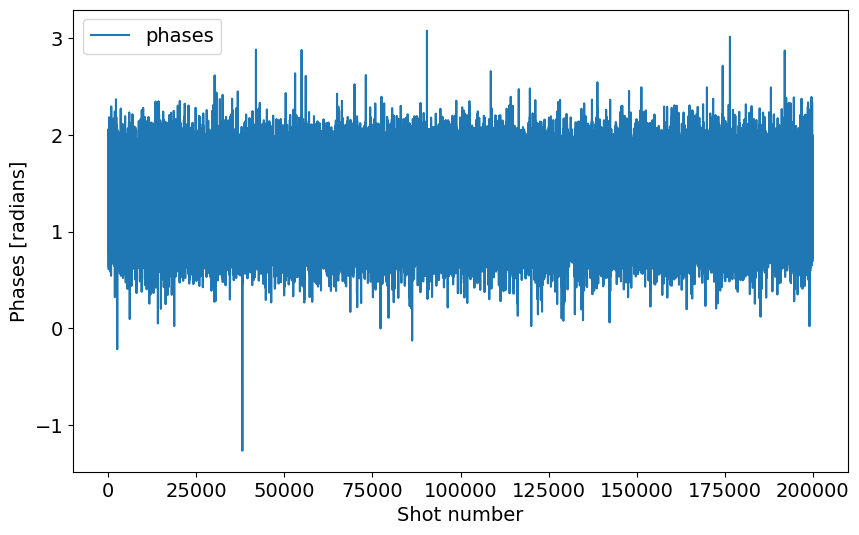

In [33]:
# Checking for drift vs. shot number

data = shot.data
i = data['Ig']
q = data['Qg']
amps = np.abs(i+1j*q)
phases = np.angle(i+1j*q)

plt.plot(amps, label='amps')
plt.ylabel('Amps [ADC units]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

plt.plot(phases, label='phases')
plt.ylabel('Phases [radians]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

# plt.plot(i, label='i')
# plt.ylabel('I [ADC units]')
# plt.xlabel('Shot number')
# plt.legend()
# plt.show()

# plt.plot(q, label='Q')
# plt.ylabel('Q [ADC units]')
# plt.xlabel('Shot number')
# plt.legend()
# plt.show()

In [16]:
shot.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00001_single_shot_qubit2.h5


Single shot drift

In [390]:
import time

Igs = []
Qgs = []
Ies = []
Qes = []
angles = []

drift_meas_time = 2*60

start_time = time.time()
elapsed_time = 0
meas_times = []
for i in tqdm(range(20)):
# for i in tqdm(range(3)):
    shot = meas.HistogramExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"single_shot_qubit{qubit_i}",
        config_file=config_path,
    )

    shot.cfg.expt = dict(
        reps=20000,
        check_f=False,
        qubit=qubit_i,
    )

    # shot.cfg.device.readout.frequency=-82.015-0.54
    shot.cfg.device.readout.gain=0.75
    # shot.cfg.device.readout.readout_length = 10 # [us]
    # shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
    # print(shot.cfg)

    shot.go(analyze=False, display=False, progress=False, save=False)
    elapsed_time = time.time() - start_time

    shot.analyze(verbose=False)

    Ig = np.average(shot.data['Ig'])
    Qg = np.average(shot.data['Qg'])
    Ie = np.average(shot.data['Ie'])
    Qe = np.average(shot.data['Qe'])
    angle = shot.data['angle']
    # print('Ig', Ig, 'Qg', Qg, 'Ie', Ie, 'Qe', Qe, 'angle', angle)

    Igs.append(Ig)
    Qgs.append(Qg)
    Ies.append(Ie)
    Qes.append(Qe)
    angles.append(angle)

    meas_times.append(elapsed_time)
    if elapsed_time > drift_meas_time: break
    time.sleep(30)

    

 45%|████▌     | 9/20 [10:56<13:22, 72.95s/it]


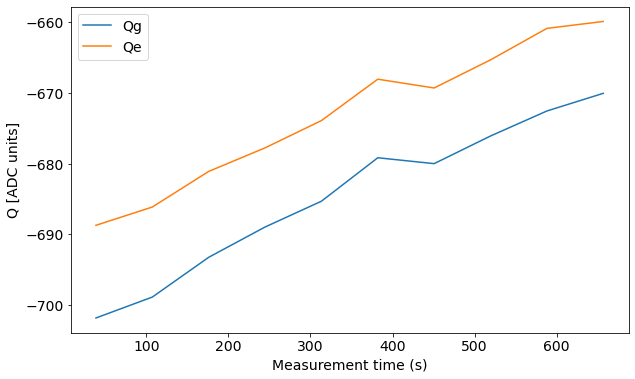

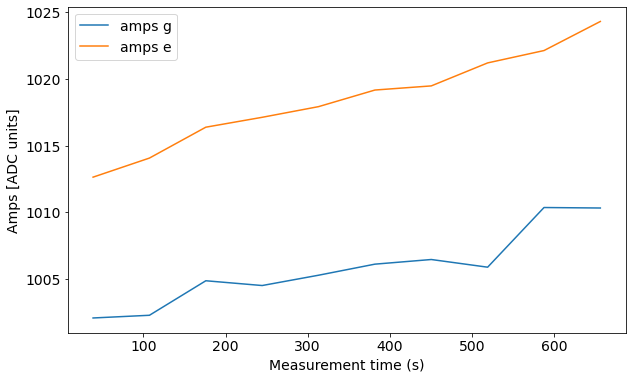

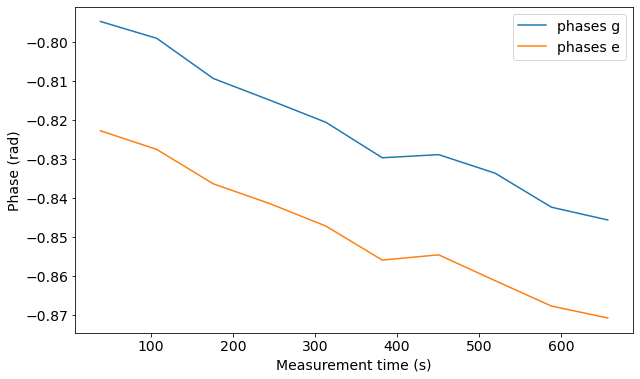

In [391]:
Igs = np.array(Igs)
Qgs = np.array(Qgs)
Ies = np.array(Ies)
Qes = np.array(Qes)
phase_gs = arctan(Igs/Qgs)
phase_es = arctan(Ies/Qes)
amps_gs = np.sqrt(Igs**2 + Qgs**2)
amps_es = np.sqrt(Ies**2 + Qes**2)

plt.plot(meas_times, Igs, label='Ig')
plt.plot(meas_times, Ies, label='Ie')
plt.ylabel('I [ADC units]')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()

plt.plot(meas_times, Qgs, label='Qg')
plt.plot(meas_times, Qes, label='Qe')
plt.ylabel('Q [ADC units]')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()

plt.plot(Qgs, Igs, label='Ig(Qg)')
plt.plot(Qes, Ies, label='Ie(Qe)')
plt.ylabel('I [ADC units]')
plt.xlabel('Q [ADC units]')
plt.legend()
plt.show()

plt.plot(meas_times, amps_gs, label='amps g')
plt.plot(meas_times, amps_es, label='amps e')
plt.ylabel('Amps [ADC units]')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()

plt.plot(meas_times, phase_gs, label='phases g')
plt.plot(meas_times, phase_es, label='phases e')
plt.ylabel('Phase (rad)')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()


### Single shot/readout optimization

In [71]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 1.0 # MHz
npts_f = 10

span_gain = 0.0
# npts_gain = 2
npts_gain = 1

span_len = 0 # us
# npts_len  2
npts_len = 1

shotopt.cfg.expt = dict(
    reps=15000,
    qubit=qubit_i,

    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.5*span_f,
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i] - 0.5*span_gain),
    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.10,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain,

    start_len=3.0,
    step_len=span_len/npts_len,
    expts_len=npts_len,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, -1, 1, 1], 'frequency': [-68.0758484925302, -817.6695229899999, 824.4487139155917, 92.93933333000001], 'gain': [0.1, 0.14, 0.1, 0.2], 'readout_length': [3.0, 3.5, 3.0, 3.0], 'relax_delay': [375, 440, 275, 300]}, 'qubit': {'f_ge': [4115.948857977556, 3453.3912760992434, 4766.946325962959, 4386.172283592115], 'f_ef': [3889.952046180199, 3331.380532810753, 4576.8312261921, 4213.348838125595], 'f_Q1_ZZ': [3448.1738335109158, 0, 3452.3213430710007, 3452.1109809499007], 'f_Q_ZZ1': [4110.747000365902, 0, 4765.913708870817, 4384.902653256242], 'f_EgGf': [2686.53594683, -1, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [-1, -1, 5884.5, 5148.4667], 'gs': [52.780871281379206, 51.02304946445798, 42.53417522582186, 3.6894442976609656, 2.646475637985887, 6.67458308496662], 'ZZs': [0.0, -5.271130541643743, -0.09970310829339724, -0.539307331083819, -5.271130541643743, 0.0, -0.9894168497467035, -1.2726243213960515, -0.09970310829339724, -0.989

  0%|          | 0/10 [00:00<?, ?it/s]

freq: 823.9487139155917, gain: 0.1, len: 3.0
	fid ge [%]: 13.193773125770857
freq: 824.0487139155917, gain: 0.1, len: 3.0
	fid ge [%]: 14.067135571185707
freq: 824.1487139155918, gain: 0.1, len: 3.0
	fid ge [%]: 16.05440362690846
freq: 824.2487139155917, gain: 0.1, len: 3.0
	fid ge [%]: 18.854590306020402
freq: 824.3487139155917, gain: 0.1, len: 3.0
	fid ge [%]: 20.680689356311877
freq: 824.4487139155917, gain: 0.1, len: 3.0
	fid ge [%]: 20.59401980066002
freq: 824.5487139155917, gain: 0.1, len: 3.0
	fid ge [%]: 19.64065468848962
freq: 824.6487139155918, gain: 0.1, len: 3.0
	fid ge [%]: 14.86716223874129
freq: 824.7487139155917, gain: 0.1, len: 3.0
	fid ge [%]: 10.207347156477098
freq: 824.8487139155917, gain: 0.1, len: 3.0
	fid ge [%]: 7.4069135637854595


(4, 0, 0)
[823.94871392 824.04871392 824.14871392 824.24871392 824.34871392
 824.44871392 824.54871392 824.64871392 824.74871392 824.84871392]
[0.1]
[3.]
Max fidelity 20.680689356311877 %
Set params: 
 angle (deg) -115.12098247272525 
 threshold 35.72292152769248 
 freq [Mhz] 824.3487139155917 
 gain [dac units] 0.1 
 readout length [us] 3.0
[[[0.13193773]]

 [[0.14067136]]

 [[0.16054404]]

 [[0.1885459 ]]

 [[0.20680689]]

 [[0.2059402 ]]

 [[0.19640655]]

 [[0.14867162]]

 [[0.10207347]]

 [[0.07406914]]]


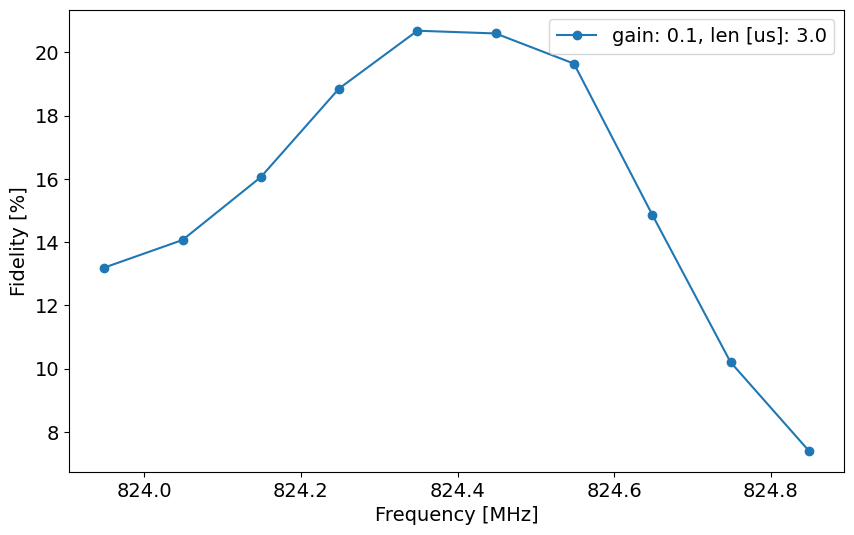

In [72]:
shotopt.analyze()
print(shotopt.data['fid'])
shotopt.display()

In [214]:
shotopt.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00000_single_shot_opt_qubit2.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_231212\\00000_single_shot_opt_qubit2.h5'

## $T_1$

Measures the qubit T1 characteristic decay time by preparing the qubit in its excited state with a $\pi$ pulse followed by a variable delay ($\tau$) before measuring the qubit's state. This exponential decay curve can be fitted in post-processing to obtain the qubit T1 time.

In [77]:
qubit_i = 3

In [337]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)

span = 100
npts = 150

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=200,
    rounds=10,
    qubit=qubit_i,
    checkEF=True,
)

# t1.cfg.device.readout.relax_delay = 300 # Wait time between experiments [us]

print(t1.cfg)

t1.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, -1, 1, 1], 'frequency': [-67.5604563688476, -818.3165832328616, 824.8647139155917, 93.52599999666671], 'frequency_ef': [-67.5604563688476, -818.3165832328616, 823.0647139155917, 92.22599999666672], 'gain': [0.16, 0.15, 0.4, 0.25], 'readout_length': [7.0, 5.0, 8.0, 7.0], 'relax_delay': [300, 525, 300, 350]}, 'qubit': {'f_ge': [4117.659535585885, 3450.4562851273354, 4766.871603044884, 4383.681408315995], 'f_ef': [3892.010624623449, 3349.941101774378, 4577.036256658536, 4210.841209697969], 'f_Q1_ZZ': [3445.2023317296585, 0, 3449.311443189216, 3449.1061351754615], 'f_Q_ZZ1': [4112.401046361381, 0, 4765.8670233481, 4382.389648653785], 'f_EgGf': [2686.53594683, 0, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [0, 0, 5890.497375, 5148.666667], 'f_f0g1': [0, 1006.52, 0, 0], 'gs': [54.18305729787911, 56.80877037961852, 42.812523932608954, 3.2287859260584977, 1.7043533039484866, 5.3832463588099975], 'ZZs': [0.0, -5.258489224504046, -0.0

  0%|          | 0/10 [00:00<?, ?it/s]

In [338]:
# TESTING
t1.save_data()
# t1 = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1_qubit3.h5')
# data = t1.analyze(data=temp_data) #, fit_slice=(0, 50))
# t1.data = data
# t1.cfg = AttrDict(attrs['config'])
# print(t1.cfg.expt.reps, t1.cfg.expt.rounds, t1.cfg.expt.expts)

# t1.display(data=data, fit=True, fit_log=False)

# print('qubit', qubit_i)
t1.analyze()
t1.display()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00001_t1_qubit3.h5
Fit T1 avgi [us]: 41.832455412835294
Fit T1 avgq [us]: 29.05157212602097


s:\Connie\experiments\qramLL_4QR2\experiments\fitting.py:65: RuntimeWarning: overflow encountered in exp
  return y0 + yscale*np.exp(-(x-x0)/decay)


Fit T1 avgq [us]: 37.3383099683629 $\pm$ 0.536392695984866
Fit T1 avgq [us]: 33.036852262892516 $\pm$ 0.3217249255309689


Fit to quasiparticle excitations

C:\Users\slab\AppData\Local\Temp\ipykernel_9480\217307492.py:11: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  temp_data.update({key:np.array(a[key])})
s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\t1.py:183: RuntimeWarning: invalid value encountered in log
  ypts_logscale = np.log(ypts_fit)


Extracted data and attrs ['config']
[ 9.99995000e-06 -6.03163357e-02 -1.03596337e-01 -1.39882967e-01
 -1.73758374e-01 -2.47293334e-01 -2.47705960e-01 -2.95138308e-01
 -3.17363690e-01 -3.75530655e-01 -4.08081889e-01 -4.30265323e-01
 -4.25357650e-01 -5.03067463e-01 -5.35696276e-01 -5.62722928e-01
 -6.08146876e-01 -6.29071654e-01 -6.54774884e-01 -6.98982719e-01
 -7.34921473e-01 -7.70207754e-01 -7.58215027e-01 -8.67956732e-01
 -8.37900053e-01 -9.68519422e-01 -9.26395906e-01 -9.43356787e-01
 -9.89575970e-01 -1.02377156e+00 -1.05647481e+00 -1.06570891e+00
 -1.14348115e+00 -1.18257107e+00 -1.28276221e+00 -1.26689408e+00
 -1.36074494e+00 -1.40047380e+00 -1.37360522e+00 -1.38294174e+00
 -1.45528511e+00 -1.40045099e+00 -1.40737360e+00 -1.56624701e+00
 -1.64830864e+00 -1.57760296e+00 -1.55712791e+00 -1.70388894e+00
 -1.74030276e+00 -1.66376604e+00 -1.85963842e+00 -1.78306898e+00
 -1.95784020e+00 -1.73858825e+00 -1.85389023e+00 -2.06494576e+00
 -1.98812216e+00 -2.13118455e+00 -2.23845319e+00 -2.20

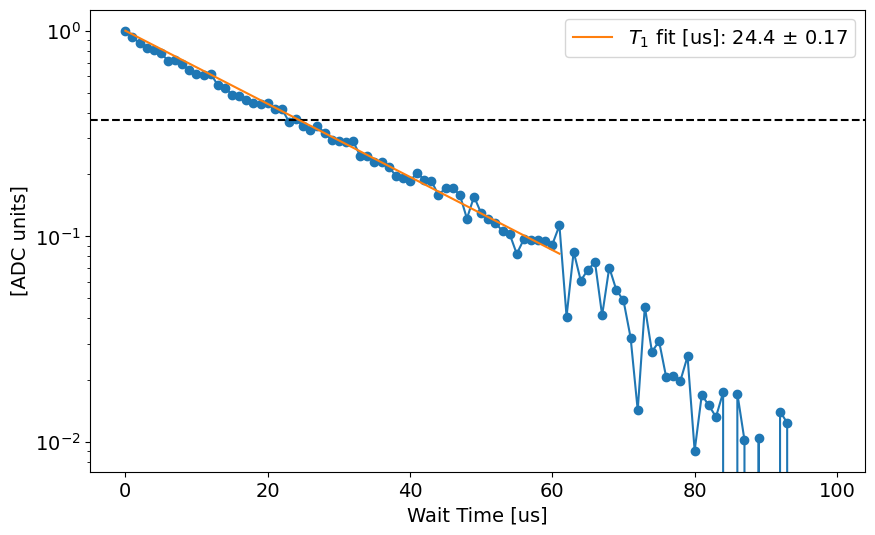

In [337]:
t1 = meas.T1Experiment(config_file=config_path,)
temp_data, attrs = prev_data(expt_path, '00003_t1_qubit2.h5')
data = t1.analyze(data=temp_data)
t1.data = data
t1.cfg = AttrDict(attrs['config'])


xpts_full = np.copy(t1.data['xpts'])
ypts_full = np.copy(t1.data['amps'])

ypts_full = (ypts_full - ypts_full[-1])/(ypts_full[0]-ypts_full[-1])

xpts_fit = np.copy(t1.data['xpts'][:-37])
ypts_fit = np.copy(ypts_full[:-37])

xpts_fit = xpts_fit[:-1]
ypts_fit = ypts_fit[:-1] # need to get rid of the 0 at the end of the sequence
print(ypts_fit)
ypts_logscale = np.log(ypts_fit)
print(ypts_logscale)
for i in range(len(xpts_fit)):
    if np.isnan(ypts_logscale[i]):
        ypts_logscale[i] = (ypts_logscale[i+1] + ypts_logscale[i-1])/2
print(ypts_logscale)


fitparams = [0.1, 20, 50]
fitparams = None
# p, pCov = meas.fitting.fitqpexp(xpts_fit, ypts_logscale, fitparams=fitparams)
p, pCov = meas.fitting.fitlogexp(xpts_fit, ypts_logscale, fitparams=fitparams)

plt.figure()
plt.yscale('log')
plt.plot(xpts_full, ypts_full,'o-')
plt.axhline(1/np.e, linestyle='--', color='k')

# captionStr = '$T_{1QP}$'+ f' fit [us]: {p[1]:.3} $\pm$ {np.sqrt(pCov[1][1]):.3}'
# captionStr += '\n$T_{1R}$'+ f' fit [us]: {p[2]:.3} $\pm$ {np.sqrt(pCov[2][2]):.3}'
# captionStr += '\n$n_{QP}$'+ f' fit [us]: {p[0]:.3} $\pm$ {np.sqrt(pCov[0][0]):.3}'
# fit_data = meas.fitting.qp_expfunc(xpts_fit, *p)

captionStr = '$T_{1}$'+ f' fit [us]: {p[0]:.3} $\pm$ {np.sqrt(pCov[0][0]):.3}'
fit_data = meas.fitting.logexpfunc(xpts_fit, *p)



fit_data = np.exp(fit_data)
plt.plot(xpts_fit, fit_data, label=captionStr)

plt.legend()
plt.xlabel("Wait Time [us]")
plt.ylabel("[ADC units]")
plt.show()

In [382]:
t1.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00001_t1_qubit3.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_230217\\00001_t1_qubit3.h5'

## $T_2$ Ramsey Fringe Experiment

Measures the qubit $T_2$ Ramsey characteristic decay time by preparing the qubit in a superposition state with a  $\frac{\pi}{2}$ pulse (about X-axis) followed by a variable delay ($\tau$) before applying another $\frac{\pi}{2}$ pulse (about X-axis) with a phase advanced by $\Delta \phi = \omega * \tau$, where $\omega$ is the Ramsey frequency.

When qubit frequency is off by $\Delta$, oscillations will be observed at $\omega+\Delta$. Iterate on this experiment, adjusting the qubit frequency, until no oscillations are observed.

This exponential decay envelope can be fitted in post-processing to obtain the qubit $T_2$ Ramsey time.

In [12]:
0.5/soc.cycles2us(50)

4.3008

In [263]:
t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)

t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    expts=300,
    step=soc.cycles2us(180), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    ramsey_freq=0.100, # [MHz]
    # step=soc.cycles2us(120), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # ramsey_freq=0.100, # [MHz]
    reps=100,
    rounds=20,
    qubits=[qubit_i],
    # qubits=[0, 1], # qZZ, qTest
    checkZZ=False,
    checkEF=False,
    # cool_qubits=[1],
    # cool_idle=9.1, # us
)
print(t2r.cfg.expt.step)
# t2r.cfg.device.readout.gain = 0.15
# t2r.cfg.device.readout.relax_delay = 3*t2r.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]
# t2r.cfg.device.qubit.pulses.pi_ge.gain = 4657
# t2r.cfg.device.qubit.pulses.pi_ge.sigma = 0.070

print(t2r.cfg)

import Pyro4.util
try:
    t2r.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

0.41852678571428575
{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, -1, 1, 1], 'frequency': [-67.5604563688476, -818.3165832328616, 824.8647139155917, 93.52599999666671], 'gain': [0.16, 0.15, 0.4, 0.25], 'readout_length': [7.0, 5.0, 8.0, 7.0], 'relax_delay': [300, 525, 300, 350]}, 'qubit': {'f_ge': [4117.659535585885, 3450.4562851273354, 4766.871603044884, 4383.681408315995], 'f_ef': [3892.010624623449, 3349.941101774378, 4577.031653061257, 4210.841209697969], 'f_Q1_ZZ': [3445.1572577243646, 0, 3449.311443189216, 3449.1061351754615], 'f_Q_ZZ1': [4112.428960914854, 0, 4765.8670233481, 4382.389648653785], 'f_EgGf': [2686.53594683, -1, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [-1, -1, 5885.95, 5148.666667], 'f_f0g1': [0, 1006.52, 0, 0], 'gs': [54.18305729787911, 56.80877037961852, 42.812523932608954, 3.2287859260584977, 1.7043533039484866, 5.3832463588099975], 'ZZs': [0.0, -5.260905516769526, -0.09988449936008692, -0.41585925233903254, -5.252491785348866, 0.0, -1.09471291

  0%|          | 0/20 [00:00<?, ?it/s]

p_amps [ 2.1858859   0.09973319 88.48782142 37.41629464 17.42486595]
ps amps 17.424865952038616 2.18588589503324 37.41629464285715
Current pi pulse frequency: 4383.681408315995
Fit frequency from amps [MHz]: 0.09973318810558786 +/- 0.00018978336280769974
Suggested new pi pulse frequencies from fit amps [MHz]:
 	0.00026681189441214725
 	-0.19973318810558788
T2 Ramsey from fit amps [us]: 37.41629464285715
Current pi pulse frequency: 4383.681408315995
Fit frequency from I [MHz]: 0.09965687819958403 +/- 0.00016249165948097378
Suggested new pi pulse frequency from fit I [MHz]:
 	4383.681751437795
 	4383.4817514377955
T2 Ramsey from fit I [us]: 37.41629464285715
Fit frequency from Q [MHz]: 0.09983773640882573 +/- 0.00016701364606454955
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4383.681570579586
 	4383.481570579586
T2 Ramsey from fit Q [us]: 37.41629464285715


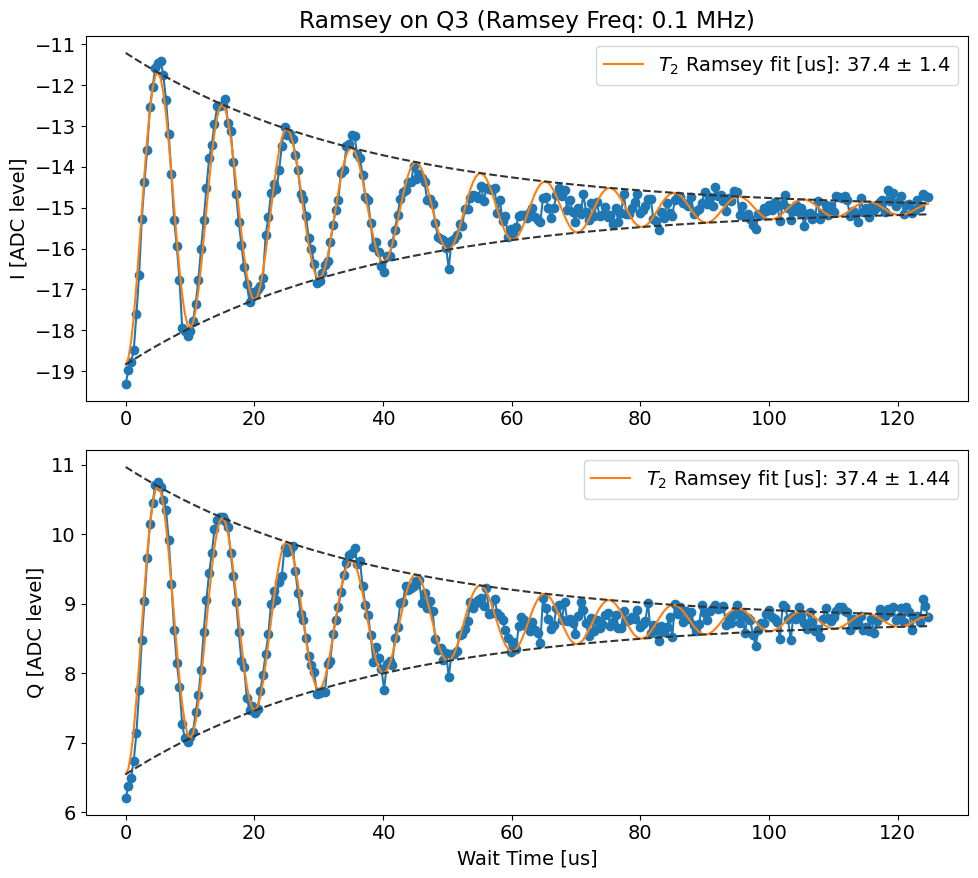

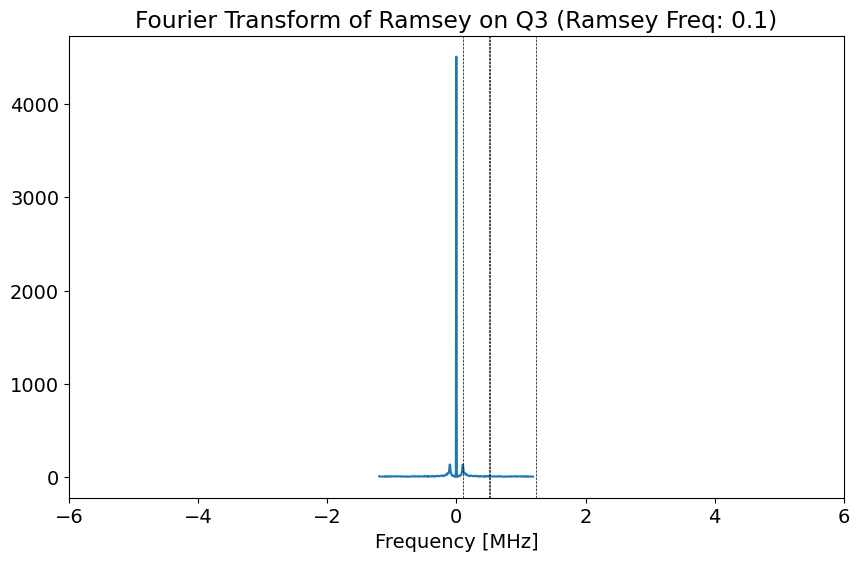

In [264]:
# # TESTING
# t2r = meas.RamseyExperiment(config_file=config_path)
# t2r.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit1.h5')
# data = t2r.analyze(data=temp_data, fit=True)
# t2r.display(data=data, fit=True)

t2r.analyze(fit=True, fit_num_sin=1)
t2r.display(fit=True, fit_num_sin=1)

data = t2r.data
xpts = data['xpts']
fourier = np.fft.fftshift(np.abs(np.fft.fft(data['avgi'])))
freqs = np.fft.fftshift(np.fft.fftfreq(len(fourier), d=(xpts[1]-xpts[0])))
plt.plot(freqs, fourier)
ZZs = np.reshape(t2r.cfg.device.qubit.ZZs, (4, 4))
for i in range(4):
    plt.axvline(t2r.cfg.expt.ramsey_freq - ZZs[qubit_i, (qubit_i+i)%4], color='k', linewidth=0.5, linestyle='--')
plt.xlabel('Frequency [MHz]')
plt.xlim(-6, 6)
# plt.ylim(0, 20000)
plt.title(f'Fourier Transform of Ramsey on Q{qubit_i} (Ramsey Freq: {t2r.cfg.expt.ramsey_freq})')
plt.show()

In [261]:
# # TESTING
# t2r = meas.RamseyExperiment(config_file=config_path)
# t2r.cfg.expt = dict(ramsey_freq=2, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit1.h5')
# data = t2r.analyze(data=temp_data, fit=True)
# t2r.display(data=data, fit=True)

t2r.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00004_ramsey_qubit2.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240218\\00004_ramsey_qubit2.h5'

In [ ]:
temp = 1e3*-h*fge/(kB*np.log(efamp_nopulse/efamp_normal))

## $T_2$ Echo

Same idea as Ramsey, but add additional $\pi$ pulses in the middle of $\tau$  which prevent the qubit from decaying as quickly.

In [166]:
0.5/soc.cycles2us(10)

17.499825

In [312]:
t2e = meas.RamseyEchoExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)

t2e.cfg.expt = dict(
    start=0, # total wait time b/w the two pi/2 pulses [us]
    step=soc.cycles2us(8), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    expts=200,
    ramsey_freq=3.0, # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    cpmg=True, # set either cp or cpmg to True
    cp=False, # set either cp or cpmg to True
    reps=100,
    rounds=20,
    qubit=qubit_i,
)

t2e.cfg.device.readout.relax_delay = 3*t2e.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(t2e.cfg)

t2e.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, -1, 1, 1], 'frequency': [-68.0758484925302, -817.8855229899999, 824.8527139155917, 92.93933333000001], 'gain': [0.1, 0.14, 0.2, 0.2], 'readout_length': [3.0, 3.5, 3.5, 3.0], 'relax_delay': 225}, 'qubit': {'f_ge': [4099.431531282737, 3450.2118220025054, 4765.554404281526, 4382.913995152254], 'f_ef': [3889.952046180199, 3349.730554526796, 4575.88394289626, 4210.296530482046], 'f_Q1_ZZ': [3448.1738335109158, 0, 3452.3213430710007, 3452.1109809499007], 'f_Q_ZZ1': [4110.747000365902, 0, 4765.913708870817, 4384.902653256242], 'f_EgGf': [2686.53594683, -1, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [-1, -1, 5885.4896, 5148.7667], 'f_f0g1': [0, 1006.52, 0, 0], 'gs': [52.780871281379206, 51.02304946445798, 42.53417522582186, 3.6894442976609656, 2.646475637985887, 6.67458308496662], 'ZZs': [0.0, -5.271130541643743, -0.09970310829339724, -0.539307331083819, -5.271130541643743, 0.0, -0.9894168497467035, -1.2726243213960515, -0.09970310

  0%|          | 0/20 [00:00<?, ?it/s]

qubit 0
Current qubit frequency: 4099.431531282737
Fit frequency from I [MHz]: 2.9998106210688933 +/- 0.003916192437194431
T2 Echo from fit I [us]: 2.3592897038257945
Fit frequency from Q [MHz]: 3.0052524624356955 +/- 0.003228003593022338
T2 Echo from fit Q [us]: 2.2591601531068353


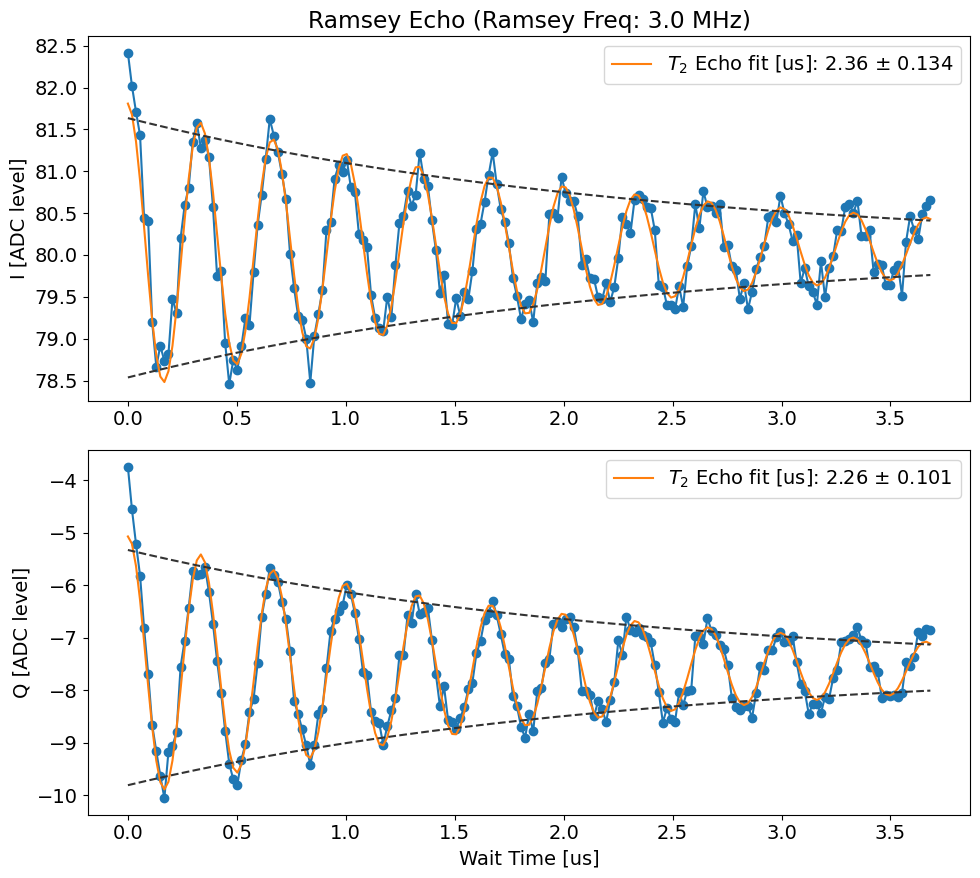

In [313]:
# # TESTING
# t2e = meas.RamseyEchoExperiment(config_file=config_path)
# t2e.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# data = t2e.analyze(data=temp_data, fit=True)
# t2e.display(data=data, fit=True)

print('qubit', qubit_i)
t2e.analyze(fit=True)
t2e.display(fit=True)

In [316]:
t2e.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_echo_qubit0.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data_220904\\00000_echo_qubit0.h5'

# Qubit ef spectroscopy

## Pulse Probe ef spectroscopy

Qubit ef frequency should be stored in <code>cfg.qubiti.f_ef</code>.

In [85]:
qEFspec = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 200
npts = 200

qEFspec.cfg.expt = dict(
    start=qEFspec.cfg.device.qubit.f_ef[qubit_i]-0.2*span, # resonator frequency to be mixed up [MHz]
    # start=qEFspec.cfg.device.qubit.f_ge[qubit_i] - 50 - span,
    # start=3435,
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=0.015*100, # ef probe constant pulse length [us]
    gain=int(10896/10), # ef pulse gain
    pulse_type='gauss', # ef pulse type
    qubit=qubit_i,
)

qEFspec.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]
# qEFspec.cfg.device.readout.gain = 0.75 # Wait time between experiments [us]
print(qEFspec.cfg)

qEFspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, -1, 1, 1], 'frequency': [-68.0758484925302, -817.8855229899999, 824.8527139155917, 92.93933333000001], 'gain': [0.1, 0.14, 0.2, 0.2], 'readout_length': [3.0, 3.5, 3.5, 3.0], 'relax_delay': 50}, 'qubit': {'f_ge': [4100.405686538423, 3450.017060203236, 4765.554404281526, 4382.696937339579], 'f_ef': [3889.952046180199, 3349.730554526796, 4575.88394289626, 4210.296530482046], 'f_Q1_ZZ': [3448.1738335109158, 0, 3452.3213430710007, 3452.1109809499007], 'f_Q_ZZ1': [4110.747000365902, 0, 4765.913708870817, 4384.902653256242], 'f_EgGf': [2686.53594683, -1, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [-1, -1, 5885.4896, 5148.7667], 'gs': [52.780871281379206, 51.02304946445798, 42.53417522582186, 3.6894442976609656, 2.646475637985887, 6.67458308496662], 'ZZs': [0.0, -5.271130541643743, -0.09970310829339724, -0.539307331083819, -5.271130541643743, 0.0, -0.9894168497467035, -1.2726243213960515, -0.09970310829339724, -0.9894168497467035, 

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3349.4108304722786, HWHM -1.6172696104049202
Found peak in I at [MHz] 3349.2995602332408, HWHM 1.451643697496023
Found peak in Q at [MHz] 3349.3941912227388, HWHM 1.6039936857636792


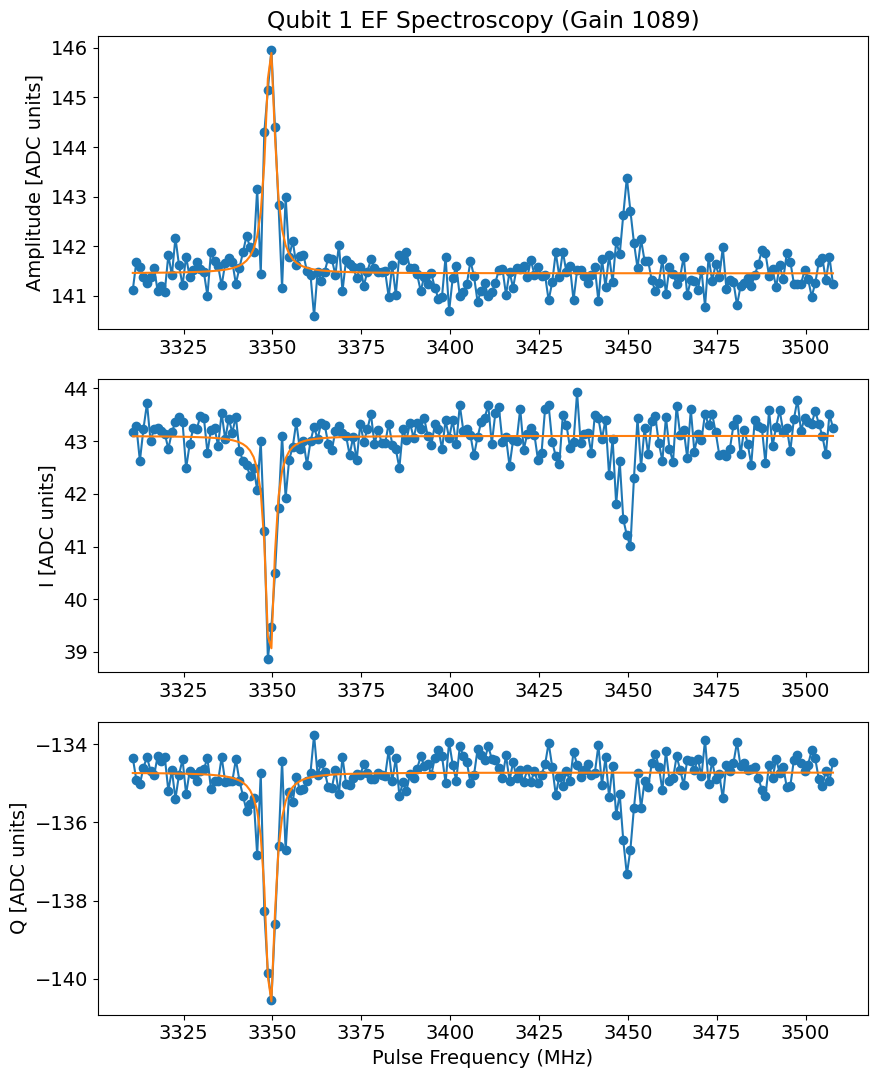

In [86]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

qEFspec.analyze(fit=True, signs=[1, -1, 1])
qEFspec.display(fit=True, signs=[1, -1, 1])

In [210]:
qEFspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00003_qubit_EF_spectroscopy_qubit3.h5


### Pulse probe EF power sweep

In [ ]:
pulseprobeEFpowspec = meas.PulseProbeEFPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"pulse_probe_ef_power_sweep_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 5
npts_f = 5

span_gain = 1000
npts_gain = 2

pulseprobeEFpowspec.cfg.expt = dict(
    start_f=pulseprobeEFpowspec.cfg.device.readout.frequency[qubit_i]-span_f/2, # Pulse frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=pulseprobeEFpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    start_gain=1,
    step_gain=int(span_gain/npts_gain), # Gain step size
    expts_gain=npts_gain, # Number experiments stepping gain from start
    reps=10,
    rounds=10, # Number averages per point
    length=10, # ef const pulse length [us]
    qubit=qubit_i,
)
pulseprobeEFpowspec.cfg.device.readout.relax_delay = 2*pulseprobeEFpowspec.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(pulseprobeEFpowspec.cfg)

pulseprobeEFpowspec.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

pulseprobeEFpowspec.analyze(lowgain=None, highgain=None)
pulseprobeEFpowspec.display()

## Length EF Rabi

In [189]:
lengthrabiEF = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabiEF_qubit{qubit_i}",
    config_file=config_path,
)

lengthrabiEF.cfg.expt = dict(
    start=soc.cycles2us(1), # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0,
    expts=101,
    reps=100000,
    gain=yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]//3, # qubit gain [DAC units],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    pulse_ge=True,
    # cool_qubits=[1],
    # cool_idle=9.1, # us
    qubits=[qubit_i],
)
# lengthrabiEF.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

import Pyro4.util
try:
    lengthrabiEF.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/101 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [186]:
lengthrabiEF.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00023_length_rabiEF_qubit1.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240212\\00023_length_rabiEF_qubit1.h5'

Pi length from avgi data [us]: 0.16014614799918786
	Pi/2 length from avgi data [us]: 0.08007307399959393

Pi length from avgq data [us]: 0.051378663727500516
Pi/2 length from avgq data [us]: 0.025689331863750258


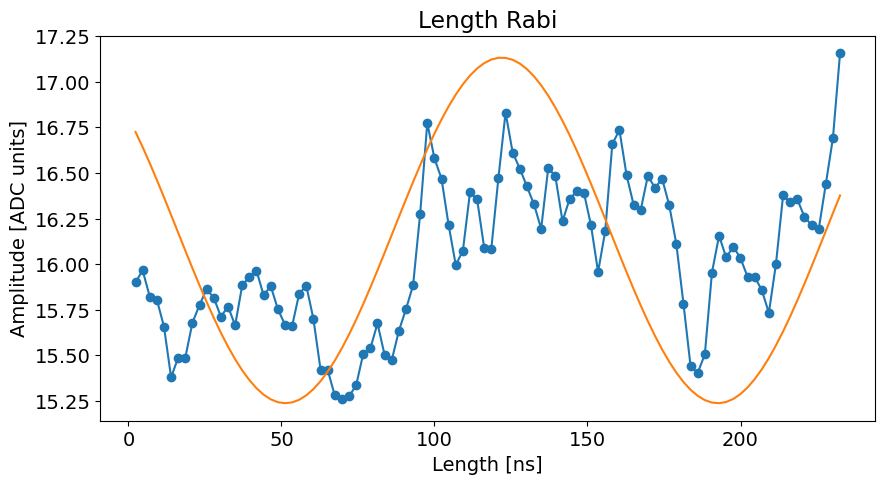

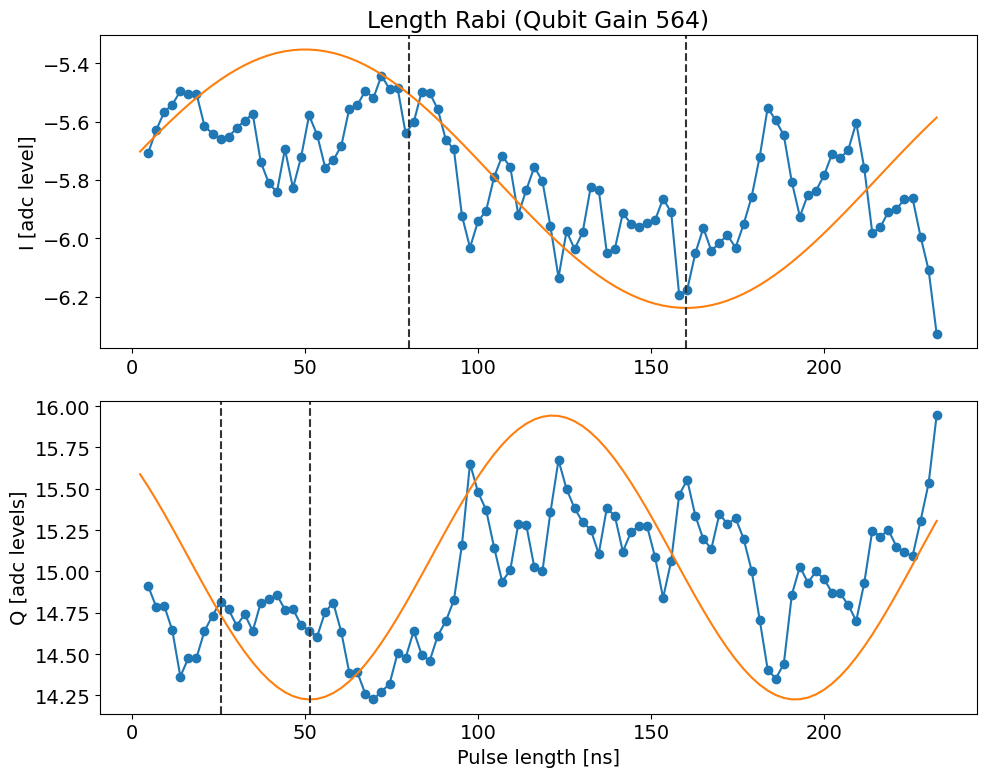

0.9470109142522497


In [187]:
# # TESTING
# # lengthrabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabiEF.data = temp_data

lengthrabiEF.analyze(fit=True, fit_func='sin')

# lengthrabiEF_fit, lengthrabiEF_fit_err = meas.fitting.get_best_fit(lengthrabiEF.data) #, fitfunc=fitter.decaysin)

lengthrabiEF.display(fit=True, fit_func='sin')

fit_axis = 'amps'

lengthrabiEF_data = lengthrabiEF.data[fit_axis]
p = lengthrabiEF.data[f'fit_{fit_axis}']
# efamp_normal = p[0]
# efamp_nopulse = p[0]
print(p[0])

# p = lengthrabiEF_fit
# if p[2] > 180: p[2] = p[2] - 360
# elif p[2] < -180: p[2] = p[2] + 360
# if p[2] < 0: pi_lenEF = (1/2 - p[2]/180)/2/p[1]
# else: pi_lenEF = (3/2 - p[2]/180)/2/p[1]
# pi_lenEF = np.max((0.9*pi_lenEF, 0.015)) # since we run the length rabi at a < max gain

# lengthrabiEF_decay = p[3]

# print(f'Use sigma {pi_lenEF} for amplitude rabi EF')

Sweep length rabi over wait times

In [151]:
wait_times = np.linspace(1, 10, 21)
saved_files = []
print(wait_times)
data_amps = []
data_avgi = []
data_avgq = []

for wait in wait_times:
    print(wait)
    lengthrabiEF = meas.LengthRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"length_rabiEF_qubit{qubit_i}",
        config_file=config_path,
    )

    lengthrabiEF.cfg.expt = dict(
        start=soc.cycles2us(1), # pulse length (sigma) [us]
        step=soc.cycles2us(1), # [us]
        # step=0,
        expts=101,
        reps=10000,
        gain=yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]//3, # qubit gain [DAC units],
        pulse_type='gauss',
        checkZZ=False,
        checkEF=True, 
        pulse_ge=False,
        cool_qubits=[1],
        cool_idle=wait, # us
        qubits=[qubit_i],
    )
    # lengthrabiEF.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

    import Pyro4.util
    try:
        lengthrabiEF.go(analyze=False, display=False, progress=True, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
    saved_files.append(lengthrabiEF.save_data())

    data_amps.append(lengthrabiEF.data['amps'])
    data_avgi.append(lengthrabiEF.data['avgi'])
    data_avgq.append(lengthrabiEF.data['avgq'])

[ 1.    1.45  1.9   2.35  2.8   3.25  3.7   4.15  4.6   5.05  5.5   5.95
  6.4   6.85  7.3   7.75  8.2   8.65  9.1   9.55 10.  ]
1.0


  0%|          | 0/101 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00002_length_rabiEF_qubit1.h5
1.45


  0%|          | 0/101 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00003_length_rabiEF_qubit1.h5
1.9


  0%|          | 0/101 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00004_length_rabiEF_qubit1.h5
2.35


  0%|          | 0/101 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00005_length_rabiEF_qubit1.h5
2.8


  0%|          | 0/101 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00006_length_rabiEF_qubit1.h5
3.25


  0%|          | 0/101 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00007_length_rabiEF_qubit1.h5
3.7


  0%|          | 0/101 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00008_length_rabiEF_qubit1.h5
4.15


  0%|          | 0/101 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00009_length_rabiEF_qubit1.h5
4.6


  0%|          | 0/101 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00010_length_rabiEF_qubit1.h5
5.05


  0%|          | 0/101 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00011_length_rabiEF_qubit1.h5
5.5


  0%|          | 0/101 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00012_length_rabiEF_qubit1.h5
5.95


  0%|          | 0/101 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00013_length_rabiEF_qubit1.h5
6.4


  0%|          | 0/101 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00014_length_rabiEF_qubit1.h5
6.8500000000000005


  0%|          | 0/101 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00015_length_rabiEF_qubit1.h5
7.3


  0%|          | 0/101 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00016_length_rabiEF_qubit1.h5
7.75


  0%|          | 0/101 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00017_length_rabiEF_qubit1.h5
8.2


  0%|          | 0/101 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00018_length_rabiEF_qubit1.h5
8.65


  0%|          | 0/101 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00019_length_rabiEF_qubit1.h5
9.1


  0%|          | 0/101 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00020_length_rabiEF_qubit1.h5
9.55


  0%|          | 0/101 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00021_length_rabiEF_qubit1.h5
10.0


  0%|          | 0/101 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00022_length_rabiEF_qubit1.h5


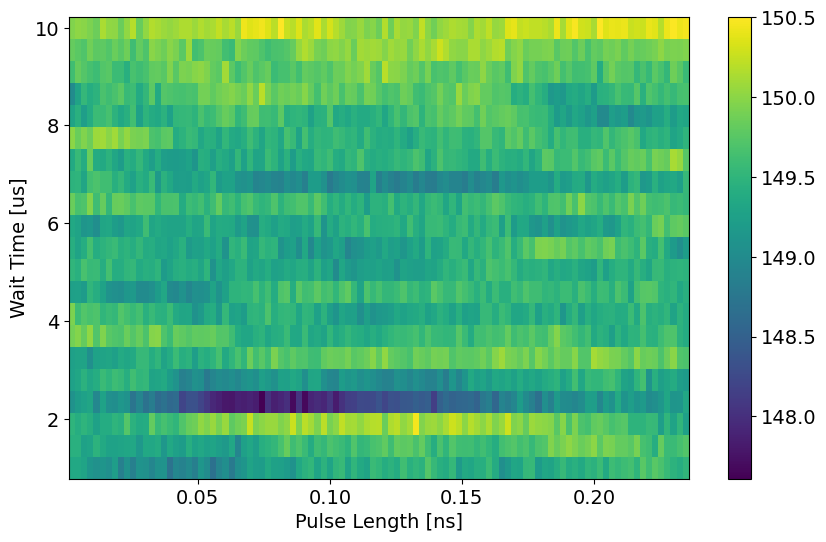

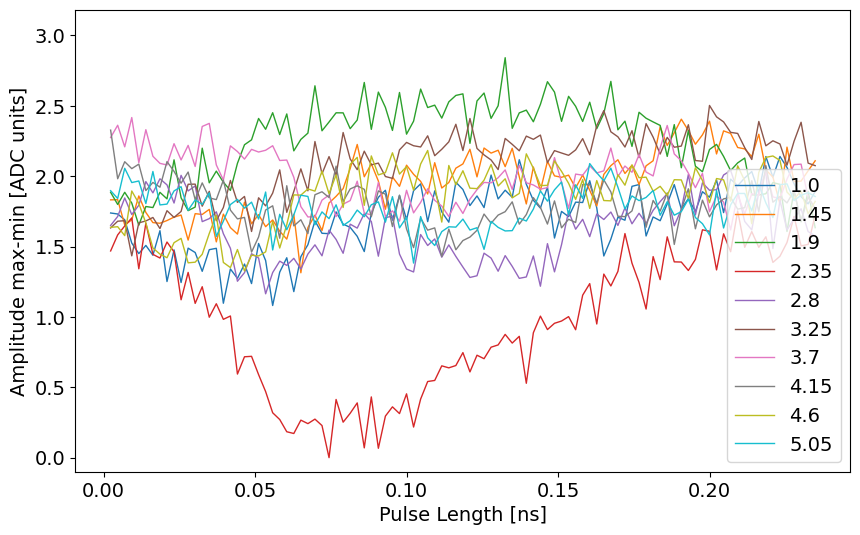

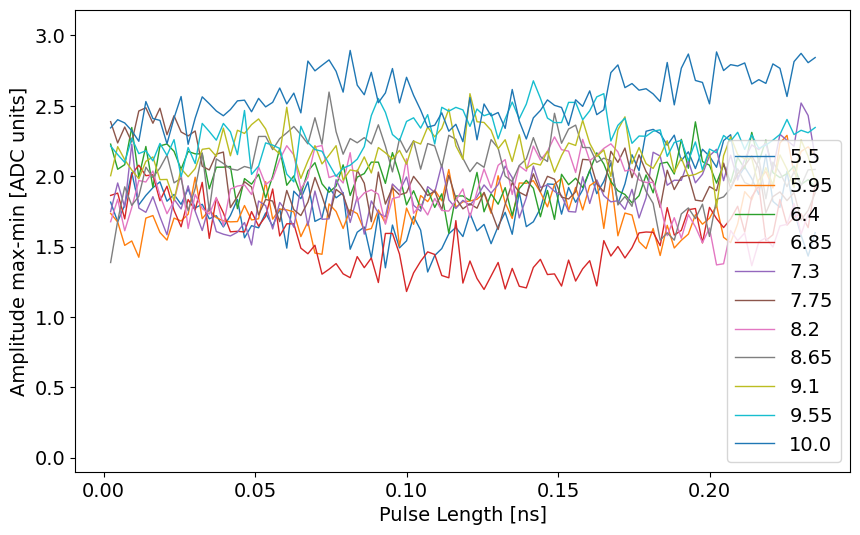

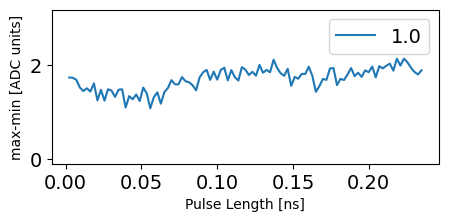

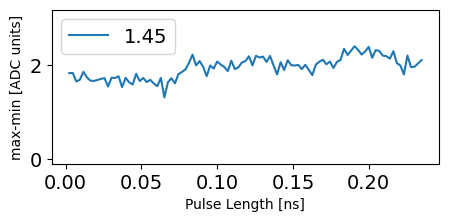

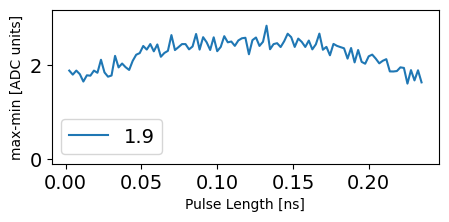

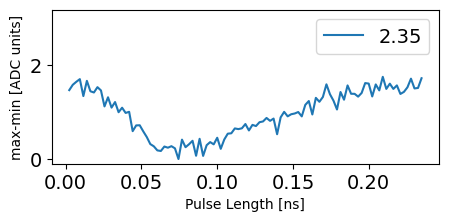

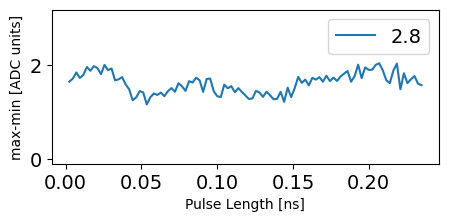

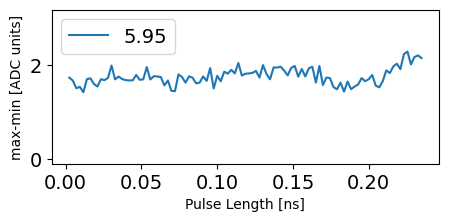

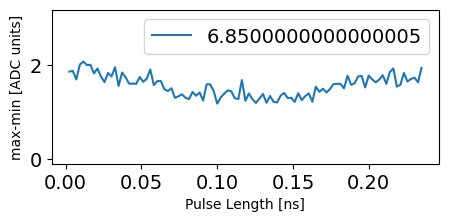

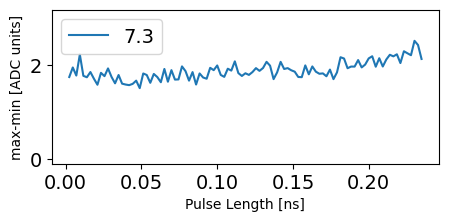

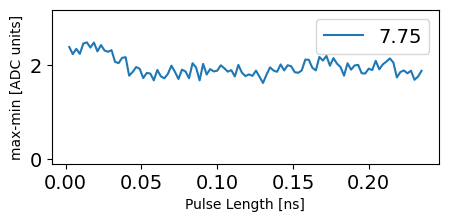

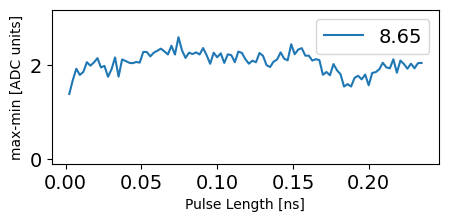

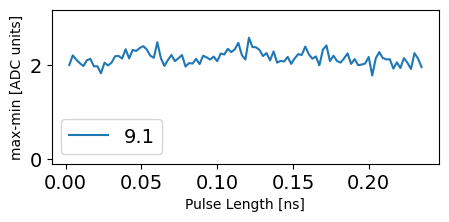

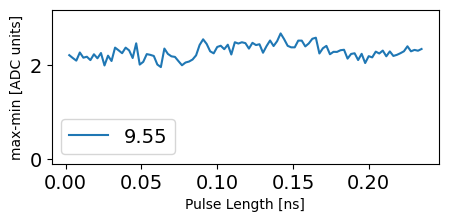

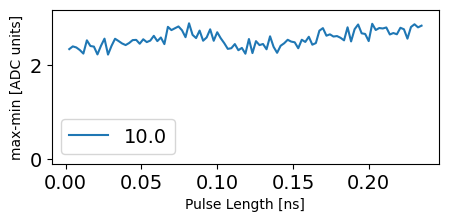

In [184]:
plot_xpts = lengthrabiEF.data['xpts']
plot_ypts = wait_times
data = np.copy(data_amps)

amplitudes = []
maxes = []
mins = []
for length_rabi in data:
    amplitudes.append(max(length_rabi) - min(length_rabi))
    maxes.append(max(length_rabi))
    mins.append(min(length_rabi))
maxes = np.array(maxes) - min(mins)
mins = np.array(mins) - min(mins)

plt.figure()
plt.pcolormesh(plot_xpts, plot_ypts, data, cmap='viridis', shading='auto')
plt.colorbar()
plt.xlabel('Pulse Length [ns]')
plt.ylabel('Wait Time [us]')
plt.show()

plt.figure()
# plt.plot(wait_times, amplitudes, label='amplitude')
# plt.plot(wait_times, maxes, '--', label='max')
# plt.plot(wait_times, mins, '--', label='min')
for i in range(len(wait_times)//2):
    plt.plot(plot_xpts, data[i]-min(data), linewidth=1, label=f'{wait_times[i]:.3}')
plt.xlabel('Pulse Length [ns]')
plt.ylabel('Amplitude max-min [ADC units]')
plt.ylim(-0.1, 1.1*(max(data)-min(data)))
plt.legend()
plt.show()

plt.figure()
# plt.plot(wait_times, amplitudes, label='amplitude')
# plt.plot(wait_times, maxes, '--', label='max')
# plt.plot(wait_times, mins, '--', label='min')
for i in range(len(wait_times)//2, len(wait_times)):
    plt.plot(plot_xpts, data[i]-min(data), linewidth=1, label=f'{wait_times[i]:.3}')
plt.xlabel('Pulse Length [ns]')
plt.ylabel('Amplitude max-min [ADC units]')
plt.legend()
#     plt.plot(plot_xpts, data[i] - min(data))
plt.ylim(-0.1, 1.1*(max(data)-min(data)))
plt.show()

for i in range(len(wait_times)):
    plt.figure(figsize=(5, 2))
    plt.plot(plot_xpts, data[i] - min(data), label=f'{wait_times[i]}')
    plt.ylim(-0.1, 1.1*(max(data)-min(data)))
    plt.xlabel('Pulse Length [ns]', fontsize=10)
    plt.ylabel('max-min [ADC units]', fontsize=10)
    plt.legend()
    plt.show()

## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [205]:
amprabiEF = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

span = 6000
# span = 20000
npts = 101

amprabiEF.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=40,
    pulse_type='gauss',
    # sigma_test=0.013, # gaussian sigma for pulse length - default from cfg [us]
    checkZZ=False,
    checkEF=True, 
    pulse_ge=True,
    # cool_qubits=[1],
    # cool_idle=9.1, # us
    qubits=[qubit_i],
)

print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, -1, 1, 1], 'frequency': [-68.0758484925302, -817.8855229899999, 824.8527139155917, 92.93933333000001], 'gain': [0.1, 0.14, 0.2, 0.2], 'readout_length': [3.0, 3.5, 3.5, 3.0], 'relax_delay': [375, 440, 275, 300]}, 'qubit': {'f_ge': [4100.405686538423, 3450.017060203236, 4765.554404281526, 4382.696937339579], 'f_ef': [3889.952046180199, 3349.730554526796, 4575.88394289626, 4210.296530482046], 'f_Q1_ZZ': [3448.1738335109158, 0, 3452.3213430710007, 3452.1109809499007], 'f_Q_ZZ1': [4110.747000365902, 0, 4765.913708870817, 4384.902653256242], 'f_EgGf': [2686.53594683, -1, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [-1, -1, 5885.4896, 5148.7667], 'f_f0g1': [0, 1006.52, 0, 0], 'gs': [52.780871281379206, 51.02304946445798, 42.53417522582186, 3.6894442976609656, 2.646475637985887, 6.67458308496662], 'ZZs': [0.0, -5.271130541643743, -0.09970310829339724, -0.539307331083819, -5.271130541643743, 0.0, -0.9894168497467035, -1.2726243213960

  0%|          | 0/40 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 1557
	Pi/2 gain from amps data [dac units]: 778
Pi gain from avgi data [dac units]: 1562
	Pi/2 gain from avgi data [dac units]: 781
Pi gain from avgq data [dac units]: 1572
	Pi/2 gain from avgq data [dac units]: 786


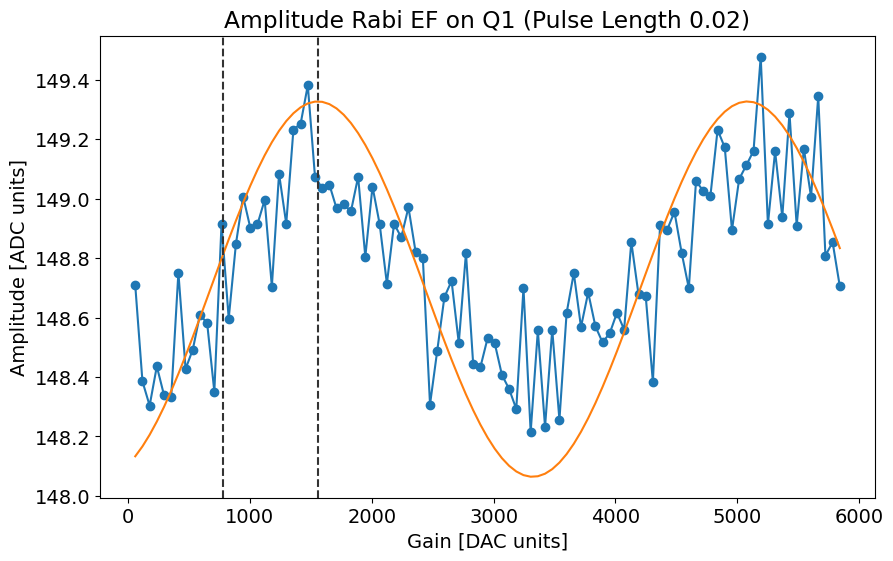

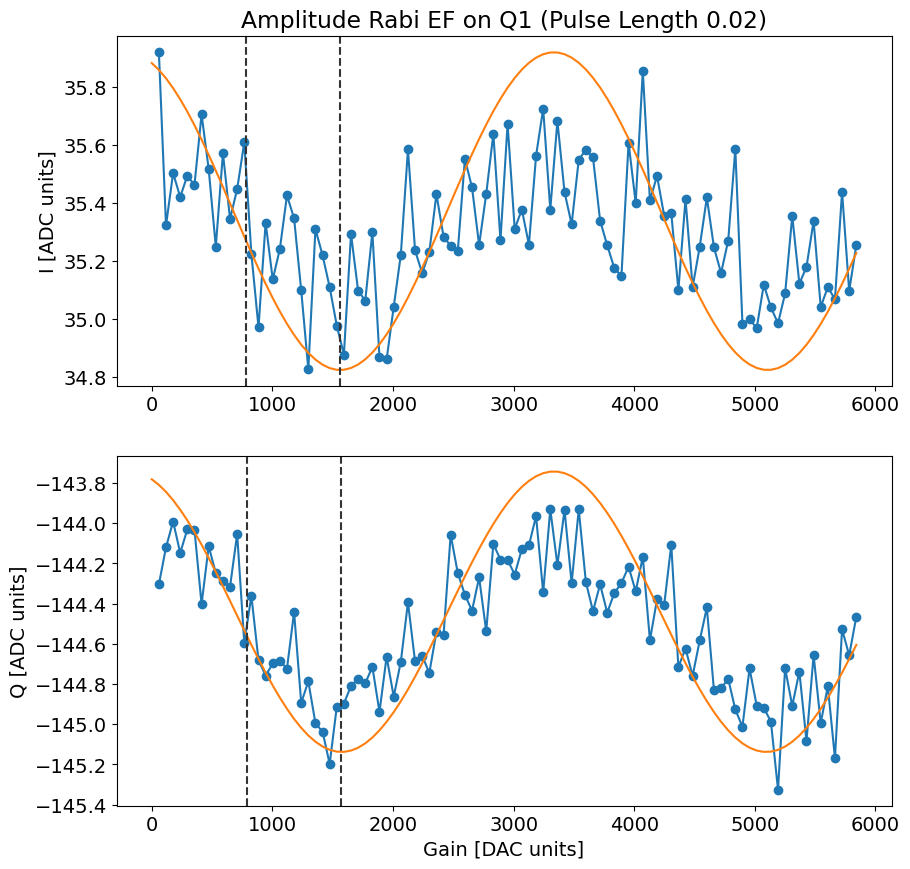

In [206]:
# # TESTING
# amprabiEF = meas.AmplitudeRabiEFExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramseyEF_qubit0.h5')
# data = amprabiEF.analyze(data=temp_data, fit=True)
# amprabiEF.display(data=data, fit=True)

amprabiEF.analyze(fit=True)
amprabiEF.display(fit=True)

In [204]:
amprabiEF.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00004_amp_rabi_EF_qubit1.h5


### Qubit temperature
Run amplitude rabi EF twice, once with and once without pulse_ge. Input the amplitude of the rabi oscillation (printed in the cell below) for each of these cases to calculate qubit temperature from the ratio.

In [242]:
# NATRUAL CONSTANTS
h = 6.62607015e-34
fge = 1e6*(amprabiEF.cfg.device.qubit.f_ge[qubit_i] + amprabiEF.cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i])
kB = 1.380649e-23
################

# print(amprabiEF.data.keys())
amps = amprabiEF.data['amps']
avgq = amprabiEF.data['avgq']

print(np.max(avgq) - np.min(avgq))
efamp_normal = 40
efamp_nopulse = abs(335-327)

print('Qubit temp [mK]:', 1e3*-h*fge/(kB*np.log(efamp_nopulse/efamp_normal)))


15.322239324928832
Qubit temp [mK]: 103.07902923184261


## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [155]:
1/(soc.cycles2us(1)*151)

2.3178576158940403

In [342]:
t2EFr = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    expts=150,
    step=soc.cycles2us(150), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    ramsey_freq=0.100, # [MHz]
    # step=soc.cycles2us(40), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # ramsey_freq=0.300, # [MHz]
    checkZZ=False,
    checkEF=True,
    reps=100,
    rounds=30,
    qubits=[qubit_i],
)
t2EFr.cfg.device.readout.frequency = t2EFr.cfg.device.readout.frequency_ef

print(t2EFr.cfg)

t2EFr.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, -1, 1, 1], 'frequency': [-67.5604563688476, -818.3165832328616, 823.0647139155917, 92.22599999666672], 'frequency_ef': [-67.5604563688476, -818.3165832328616, 823.0647139155917, 92.22599999666672], 'gain': [0.16, 0.15, 0.4, 0.25], 'readout_length': [7.0, 5.0, 8.0, 7.0], 'relax_delay': [300, 525, 300, 350]}, 'qubit': {'f_ge': [4117.659535585885, 3450.4562851273354, 4766.871603044884, 4383.681408315995], 'f_ef': [3892.010624623449, 3349.941101774378, 4577.036256658536, 4210.899264670438], 'f_Q1_ZZ': [3445.2023317296585, 0, 3449.311443189216, 3449.1061351754615], 'f_Q_ZZ1': [4112.401046361381, 0, 4765.8670233481, 4382.389648653785], 'f_EgGf': [2686.53594683, 0, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [0, 0, 5890.497375, 5148.666667], 'f_f0g1': [0, 1006.52, 0, 0], 'gs': [54.18305729787911, 56.80877037961852, 42.812523932608954, 3.2287859260584977, 1.7043533039484866, 5.3832463588099975], 'ZZs': [0.0, -5.258489224504046, -0.0

  0%|          | 0/30 [00:00<?, ?it/s]

p_amps [ 1.63767447e+00  1.00273310e-01 -1.00678669e+02  1.73765309e+01
  2.65990901e+01]
ps amps 26.59909009862857 1.6376744720540617 17.376530868531948
Current pi pulse frequency: 4210.899264670438
Fit frequency from amps [MHz]: 0.10027330960184014 +/- 0.0009357051678308179
Suggested new pi pulse frequencies from fit amps [MHz]:
 	-0.00027330960184013264
 	-0.20027330960184014
T2 Ramsey from fit amps [us]: 17.376530868531948
Current pi pulse frequency: 4210.899264670438
Fit frequency from I [MHz]: 0.10204628129575748 +/- 0.0018521033574918503
Suggested new pi pulse frequency from fit I [MHz]:
 	4210.897218389143
 	4210.697218389142
T2 Ramsey from fit I [us]: 15.485491071943866
Fit frequency from Q [MHz]: 0.09943402322675457 +/- 0.0005678134177008815
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4210.899830647211
 	4210.6998306472115
T2 Ramsey from fit Q [us]: 17.79815284001112


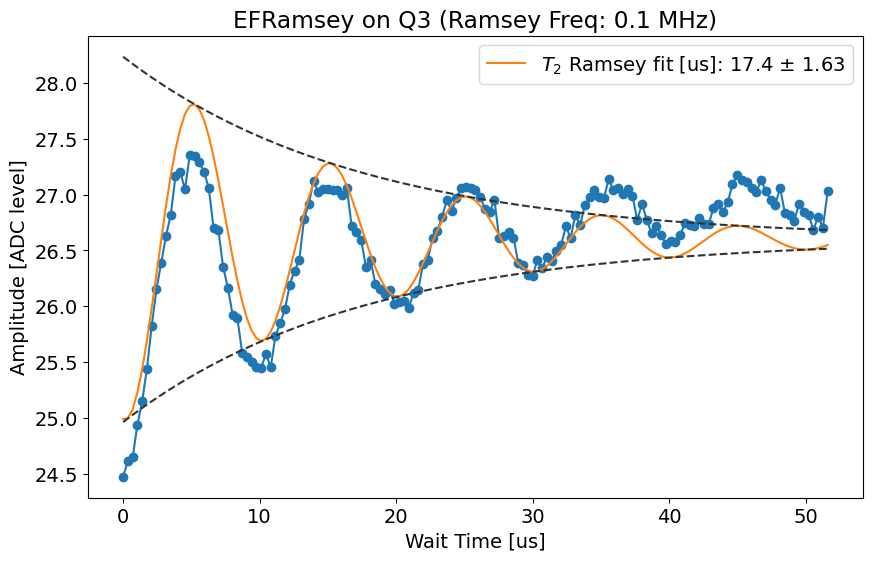

In [343]:
# # TESTING
# t2EFr = meas.RamseyEFExperiment(config_file=config_path)
# t2EFr.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data = prev_data(expt_path, '00000_ramseyEF_qubit0.h5')
# temp_data = temp_data[0]
# data = t2EFr.analyze(data=temp_data, fit=True)
# t2EFr.display(data=data, fit=True)

t2EFr.analyze(fit=True)
t2EFr.display(fit=True)

In [344]:
t2EFr.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00001_ramseyEF_qubit3.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240218\\00001_ramseyEF_qubit3.h5'

# AC stark shift

Determine how much effective power is being applied for a drive detuned from qubit frequency

In [296]:
acspec = meas.ACStarkShiftPulseProbeExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ac_stark_shift_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 100
npts_f = 300

span_gain = 1000
npts_gain = 25

pump_params=dict(
    ch=1,
    type='full',
    nyquist=2,
)

acspec.cfg.expt = dict(
    # start_f=acspec.cfg.device.qubit.f_ge[qubit_i]-span_f/2, # Pulse frequency [MHz]
    start_f=acspec.cfg.device.qubit.f_ge[qubit_i]-0.25*span_f, # Pulse frequency [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    start_gain=0, # pump tone gain
    step_gain=int(span_gain/npts_gain),
    expts_gain=npts_gain+1,
    # pump_params=acspec.cfg.hw.soc.dacs.swap,

    pump_params=pump_params,
    # pump_freq=3300,
    pump_freq=acspec.cfg.device.qubit.f_ge[qubit_i]-20,
    # pump_freq=acspec.cfg.device.qubit.f_EgGf[2],
    pump_length=10, # [us]

    qubit_length=1, # [us]
    qubit_gain=2814,
    pulse_type='const',

    reps=100,
    rounds=10, # Number averages per point
    qubit=qubit_i,
)
acspec.cfg.device.readout.relax_delay = 25
print(acspec.cfg)

acspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, -1, 1, 1], 'frequency': [-68.0758484925302, -817.8855229899999, 824.8527139155917, 92.93933333000001], 'gain': [0.1, 0.14, 0.2, 0.2], 'readout_length': [3.0, 3.5, 3.5, 3.0], 'relax_delay': 25}, 'qubit': {'f_ge': [4099.431531282737, 3450.2118220025054, 4765.554404281526, 4382.913995152254], 'f_ef': [3889.952046180199, 3349.730554526796, 4575.88394289626, 4210.296530482046], 'f_Q1_ZZ': [3448.1738335109158, 0, 3452.3213430710007, 3452.1109809499007], 'f_Q_ZZ1': [4110.747000365902, 0, 4765.913708870817, 4384.902653256242], 'f_EgGf': [2686.53594683, -1, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [-1, -1, 5885.4896, 5148.7667], 'f_f0g1': [0, 1006.52, 0, 0], 'gs': [52.780871281379206, 51.02304946445798, 42.53417522582186, 3.6894442976609656, 2.646475637985887, 6.67458308496662], 'ZZs': [0.0, -5.271130541643743, -0.09970310829339724, -0.539307331083819, -5.271130541643743, 0.0, -0.9894168497467035, -1.2726243213960515, -0.099703108

  0%|          | 0/26 [00:00<?, ?it/s]

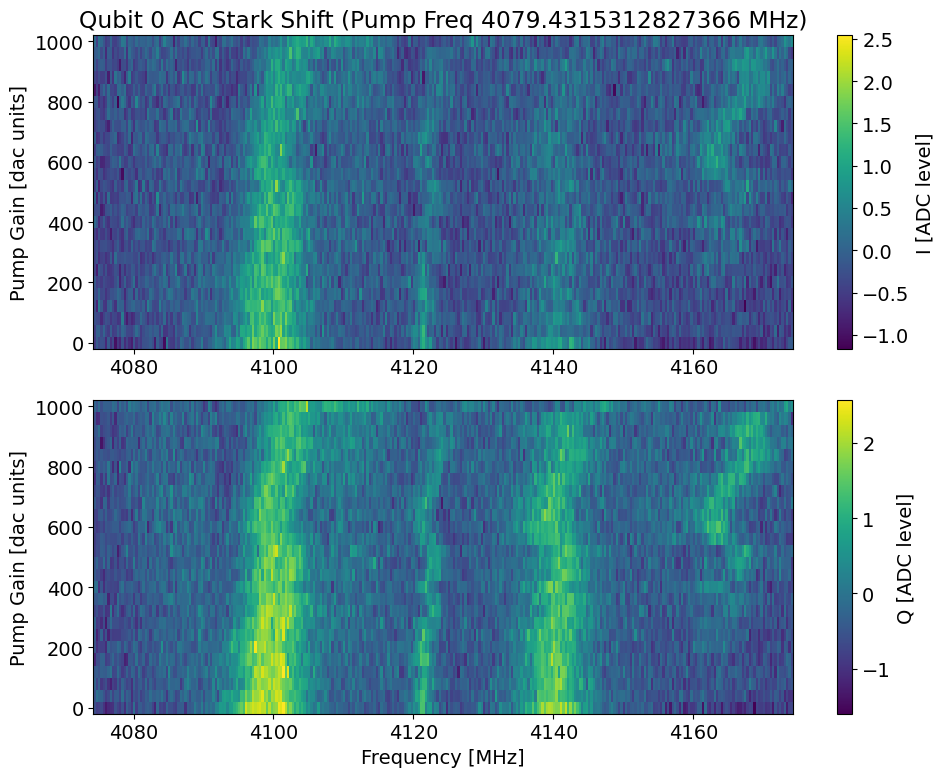

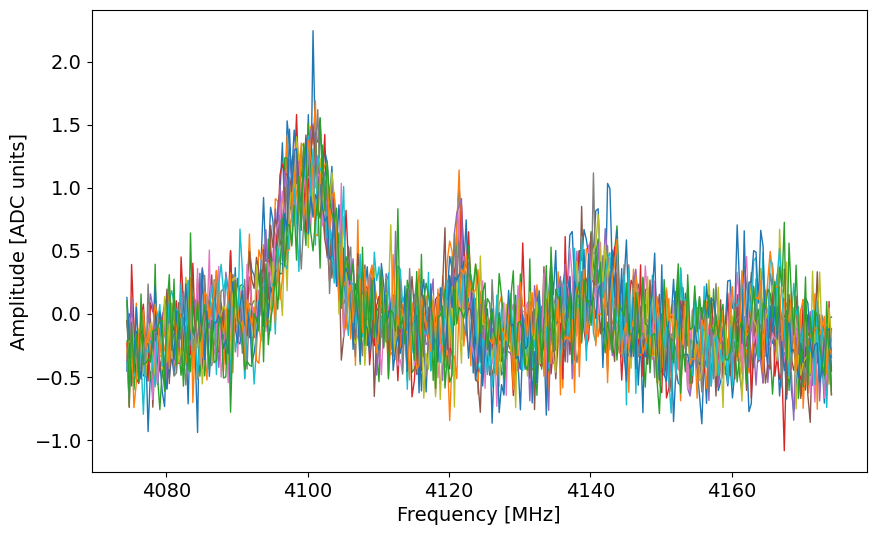

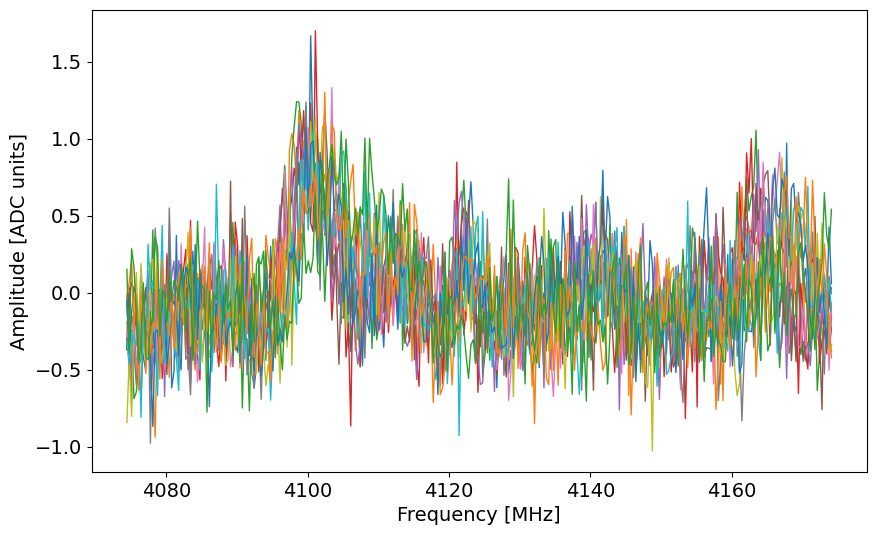

In [297]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = acspec.analyze(data=temp_data)

acspec.analyze()
acspec.display()

data = np.copy(acspec.data['amps'])
for i in range(len(data)):
    data[i] -= np.average(data[i])
freqpts = acspec.data['freqpts'] # inner sweep
gainpts = acspec.data['gainpts'] # outer sweep

plt.figure()
for i in range(len(gainpts)//2):
    plt.plot(freqpts, data[i], linewidth=1, label=f'gain {gainpts[i]}')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Amplitude [ADC units]')
# plt.legend()
plt.show()

plt.figure()
for i in range(len(gainpts)//2, len(gainpts)):
    plt.plot(freqpts, data[i], linewidth=1, label=f'gain {gainpts[i]}')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Amplitude [ADC units]')
# plt.legend()
plt.show()

In [298]:
acspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240212\00001_ac_stark_shift_qubit0.h5


# Single qubit RB

In [20]:
# qubit_i = 3
qubits = [3]

{'device': {'qubit': {'f_ge': [4115.6290596912495, 3452.4637168981253, 4766.8208180553465, 4386.208444751211], 'f_ef': [3887.651880298383, 3355.138705247387, 4577.0649811867825, 4213.264346730453], 'f_Q1_ZZ': [3447.1221975757453, 0, 3451.327108416351, 3451.125854046987], 'f_Q_ZZ1': [4110.426375461386, 0, 4765.724536912047, 4384.870206942213], 'f_EgGf': [2686.53594683, -1, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [-1, -1, 5890.85, 5150.8], 'gs': [53.86111790753793, 55.951615253475715, 42.896055738679614, 1.2556674383426387, 2.535432566502201, 6.608656393450753], 'ZZs': [0.0, -5.226607855765906, -0.05099603623511939, -0.4481907383133148, -5.403789227313155, 0.0, -1.1087598229155446, -1.1607238548440364, -0.05099603623511939, -1.1087598229155446, 0.0, -0.5542295844597902, -0.6328576128362329, -1.2534147280366597, -0.5542295844597902, 0.0], 'T1': [50, 88, 42, 75], 'pulses': {'pi_ge': {'gain': [28082, 16422, 11072, 2583], 'sigma': [0.015, 0.01, 0.006, 0.015], 'half_gain': ['None', 'None',

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)


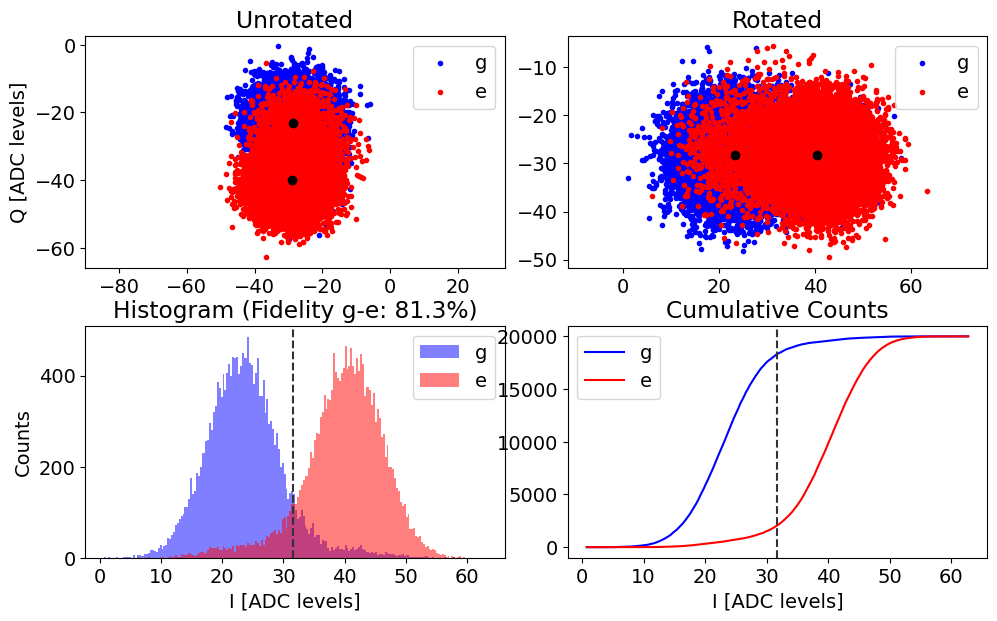

ge fidelity (%): 81.29203230080752
Qubit  (0)


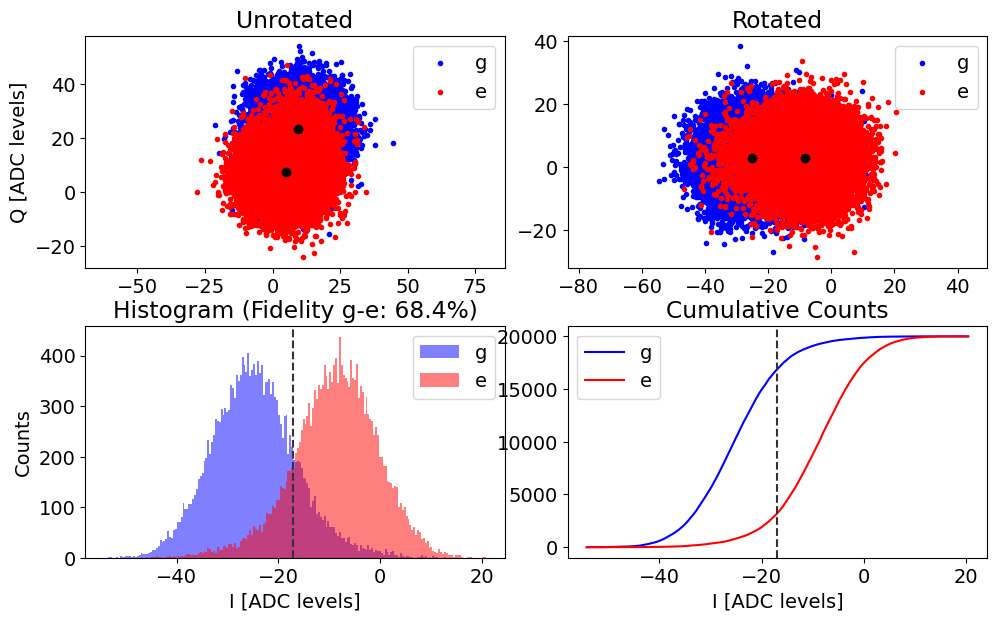

ge fidelity (%): 68.37670941773546
thresholds=[-17.109531692274196, 0, 0, 31.5857842674507]
angles=[105.14693582768304, 0, 0, 90.87483010640942]
ge_avgs=[[9.2338755526658, 23.085032964889468, 4.935098504551365, 7.825155201560468], array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), [-28.644573456121346, -23.31941798483207, -28.87317724810401, -39.36664447453955]]
counts_calib=[array([15116,  3029,  1505,   350]), array([ 2722, 15524,   241,  1513]), array([ 1542,   367, 14920,  3171]), array([  441,  1850,  2762, 14947])]


  0%|          | 0/10 [00:00<?, ?it/s]

In [332]:
rbprog = meas.SimultaneousRBExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb1Q_qubit{qubit_i}",
    config_file=config_path,
)

rbprog.cfg.expt = dict(
    start=1, # rb depth start
    step=25, # step rb depth
    expts=10, # number steps
    reps=1000, # number averages per unique sequence
    variations=100, # number different sequences per depth
    gate_char=None, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    use_EgGf_subspace=False, # specifies whether to run RB treating EgGf as the TLS subspace
    qubits=[qubit_i], # the qubits to perform simultaneous RB on (if eg-gf, q should be qA != 1)
    # qubits=qubits,
    # qDrive=qubits[0],
    singleshot_reps=20000, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None
)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

import Pyro4.util
try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

[9.98924566e-01 9.54622923e-01 1.71545796e-04]
1.9994714226783056e-06 1.2302997130272488 1.2410489799766882
Running regular RB 
Depolarizing parameter p from fit: 0.9989245659486522 +/- 0.001414026669719601
Average RB gate error: 0.0005377170256739561 +/- 0.0007070133348598005
	Fidelity=1-error: 0.999462282974326 +/- 0.0007070133348598005


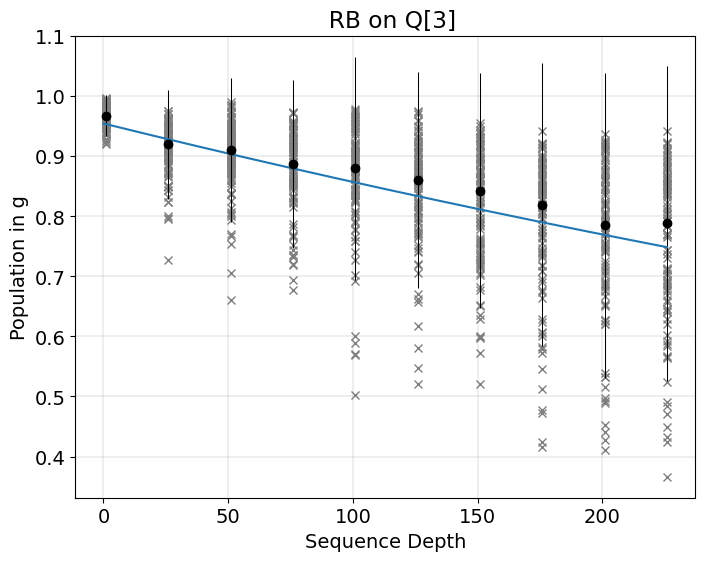

In [333]:
rbprog.analyze(fit=True)
rbprog.display(fit=True, qubit=[qubit_i])

In [326]:
p_irb = 0.9938804646407754
p_rb = 0.9462070281105198  
print(100*meas.fitting.rb_error(p_rb, 2),'% average error')
print(100*(1-meas.fitting.rb_gate_fidelity(p_rb, p_irb, 2)), '% gate error')

2.6896485944740034 % average error
-2.5191863468534414 % gate error


In [ ]:
qDrive = qubits[0]
setup_ZZ = 0

In [411]:
rbprog.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_rb1Q_qubit0.h5


TypeError: Object dtype dtype('O') has no native HDF5 equivalent

# Repeat over time

In [155]:
import time

Qubit temperature repeat over time

In [157]:
qubit_i = 1

In [170]:
debug = False

start_time = time.time()

all_temps = []
times = []
saved_files_normal = []
saved_files_nopulse = []

if debug:
    max_time = 5*60
    print_time = 0
    wait_time = 0
else:
    max_time = 13*60*60
    print_time = 0.5*60*60
    wait_time = 0*60

time_of_last_print = time.time()



# NATURAL CONSTANTS
h = 6.62607015e-34
kB = 1.380649e-23
################

In [171]:
while time.time() - start_time < max_time:
    
    try:
        lengthrabiEF = meas.LengthRabiExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"length_rabiEF_qubit{qubit_i}",
            config_file=config_path,
        )
        lengthrabiEF.cfg.expt = dict(
            start=soc.cycles2us(3), # pulse length (sigma) [us]
            step=soc.cycles2us(4), # [us]
            # step=0.001,
            expts=51,
            reps=3000,
            gain=yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]//3, # qubit gain [DAC units],
            pulse_type='gauss',
            checkZZ=False,
            checkEF=True, 
            qubits=[qubit_i],
        )

        lengthrabiEF.go(analyze=False, display=False, progress=True, save=False)
        lengthrabiEF.analyze(fit=True, fit_func='sin')
        saved_files_normal.append(lengthrabiEF.save_data())


        lengthrabiEF2 = meas.LengthRabiExperiment(
            soccfg=soc,
            path=expt_path,
            prefix="length_rabi_EF"+f"_qubit{qubit_i}",
            config_file=config_path,
        )
        
        lengthrabiEF2.cfg.expt = dict(
            start=soc.cycles2us(3), # pulse length (sigma) [us]
            step=soc.cycles2us(4), # [us]
            # step=0.001,
            expts=51,
            reps=10000,
            gain=yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]//3, # qubit gain [DAC units],
            pulse_type='gauss',
            checkZZ=False,
            checkEF=True, 
            pulse_ge=False,
            qubits=[qubit_i],
        )

        lengthrabiEF2.go(analyze=False, display=False, progress=True, save=False)
        lengthrabiEF2.analyze(fit=True, fit_func='sin')


        # fit_axis = 'amps'
        fit_axis = 'avgq'

        lengthrabiEF_data = lengthrabiEF.data[fit_axis]
        p = lengthrabiEF.data[f'fit_{fit_axis}']
        efamp_normal = p[0]

        lengthrabiEF2_data = lengthrabiEF2.data[fit_axis]
        p = lengthrabiEF2.data[f'fit_{fit_axis}']
        efamp_nopulse = p[0]

        fge = 1e6*(lengthrabiEF2.cfg.device.qubit.f_ge[qubit_i] + lengthrabiEF2.cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i])

        temp = 1e3*-h*fge/(kB*np.log(efamp_nopulse/(efamp_normal+efamp_nopulse)))
        all_temps.append(temp)
        times.append(time.time()-start_time)
        saved_files_nopulse.append(lengthrabiEF2.save_data())

        print('yscale normal:', efamp_normal)
        print('yscale no pulse:', efamp_nopulse)
    except Exception as e:
        print(e)

    time.sleep(wait_time)

    if time.time() - time_of_last_print > print_time:
        print('all_temps =', all_temps)
        print('times =', times)
        print('saved_files_normal=', saved_files_normal)
        print('saved_files_nopulse=', saved_files_nopulse)
        time_of_last_print = time.time()
        lengthrabiEF.display(fit=True, fit_func='sin')
        lengthrabiEF2.display(fit=True, fit_func='sin')



  0%|          | 0/51 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240131\00065_length_rabiEF_qubit1.h5


  0%|          | 0/51 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240131\00065_length_rabi_EF_qubit1.h5
yscale normal: 5.024811957868651
yscale no pulse: 0.6248457249070755


  0%|          | 0/51 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240131\00066_length_rabiEF_qubit1.h5


  0%|          | 0/51 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240131\00066_length_rabi_EF_qubit1.h5
yscale normal: 5.176664188351922
yscale no pulse: 0.45584828066914446


  0%|          | 0/51 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240131\00067_length_rabiEF_qubit1.h5


  0%|          | 0/51 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240131\00067_length_rabi_EF_qubit1.h5
yscale normal: 4.549018587360593
yscale no pulse: 0.5349303438661651


  0%|          | 0/51 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240131\00068_length_rabiEF_qubit1.h5


  0%|          | 0/51 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240131\00068_length_rabi_EF_qubit1.h5
yscale normal: 4.857296158612145
yscale no pulse: 0.5386397769516692


  0%|          | 0/51 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240131\00069_length_rabiEF_qubit1.h5


  0%|          | 0/51 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240131\00069_length_rabi_EF_qubit1.h5
yscale normal: 4.915963289962833
yscale no pulse: 0.5924894052044608


  0%|          | 0/51 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240131\00070_length_rabiEF_qubit1.h5


  0%|          | 0/51 [00:00<?, ?it/s]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240131\00070_length_rabi_EF_qubit1.h5
yscale normal: 5.07600758983891
yscale no pulse: 0.5547770910780657


  0%|          | 0/51 [00:00<?, ?it/s]

KeyboardInterrupt: 

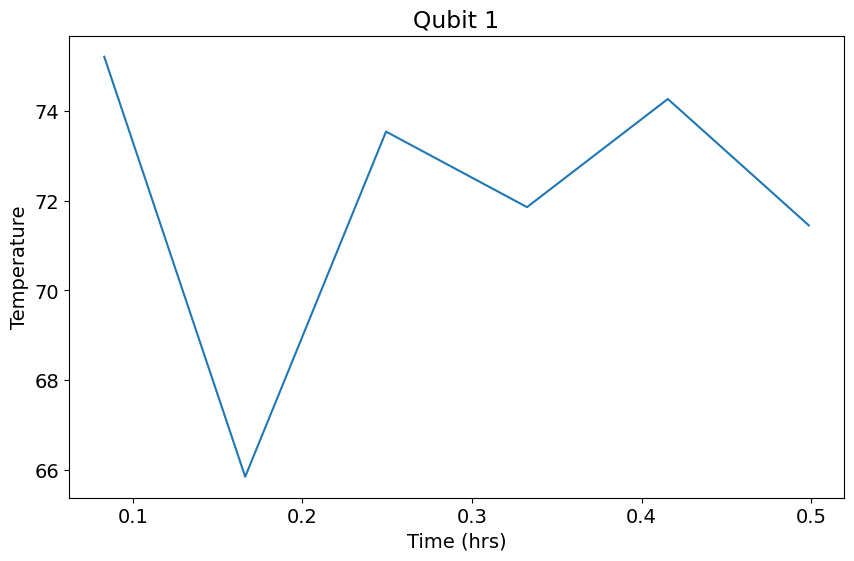

In [172]:
times = np.asarray(times)
plt.figure(figsize=(10, 6))
plt.plot(times/60/60, all_temps)
plt.title(f'Qubit {qubit_i}')
plt.xlabel('Time (hrs)')
plt.ylabel('Temperature')
plt.show()

In [ ]:
all_temps = []
h = 6.62607015e-34
kB = 1.380649e-23
for i in range(1, 62):
    lengthrabiEF = meas.LengthRabiExperiment(config_file=config_path,)
    if i < 10: temp_data, attrs = prev_data(expt_path, f'0000{i}_length_rabiEF_qubit1.h5')
    else: temp_data, attrs = prev_data(expt_path, f'000{i}_length_rabiEF_qubit1.h5')
    lengthrabiEF.cfg = AttrDict(attrs['config'])
    lengthrabiEF.data = temp_data

    lengthrabiEF.analyze(fit=True, fit_func='sin')

    # lengthrabiEF_fit, lengthrabiEF_fit_err = meas.fitting.get_best_fit(lengthrabiEF.data) #, fitfunc=fitter.decaysin)

    fit_axis = 'avgq'

    lengthrabiEF_data = lengthrabiEF.data[fit_axis]
    p = lengthrabiEF.data[f'fit_{fit_axis}']
    efamp_normal = p[0]

    lengthrabiEF2 = meas.LengthRabiExperiment(config_file=config_path,)
    if i < 10: temp_data, attrs = prev_data(expt_path, f'0000{i}_length_rabi_EF_qubit1.h5')
    else: temp_data, attrs = prev_data(expt_path, f'000{i}_length_rabi_EF_qubit1.h5')
    lengthrabiEF2.cfg = AttrDict(attrs['config'])
    lengthrabiEF2.data = temp_data

    lengthrabiEF2.analyze(fit=True, fit_func='sin')

    lengthrabiEF2_data = lengthrabiEF2.data[fit_axis]
    p = lengthrabiEF2.data[f'fit_{fit_axis}']
    efamp_nopulse = p[0]

    qubit_i = lengthrabiEF2.cfg.expt.qubits[0]

    fge = 1e6*(lengthrabiEF2.cfg.device.qubit.f_ge[qubit_i] + lengthrabiEF2.cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i])

    temp = 1e3*-h*fge/(kB*np.log(efamp_nopulse/(efamp_normal+efamp_nopulse)))
    all_temps.append(temp)

Single shot repeat over time

In [53]:
debug = False

start_time = time.time()

all_fids = []
all_T2R = []
all_T2R_err = []
times = []

if debug:
    max_time = 5*60
    print_time = 0
    wait_time = 0
else:
    max_time = 50*60*60
    print_time = 3*60*60
    wait_time = 10*60

time_of_last_print = time.time()
while time.time() - start_time < max_time:
    times.append(time.time()-start_time)

    shot = meas.HistogramExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"single_shot_qubit{qubit_i}",
        config_file=config_path,
    )

    shot.cfg.expt = dict(
        reps=20000,
        check_f=False,
        qubit=qubit_i,
    )
    shot.go(analyze=False, display=debug, progress=False, save=False)
    shot.analyze(verbose=False)
    all_fids.append(shot.data['fids'][0])


    t2r = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{qubit_i}",
        config_file=config_path,
    )

    t2r.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(20), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
        expts=150,
        ramsey_freq=0.5, # [MHz]
        reps=100,
        rounds=20,
        qubits=[qubit_i],
        checkZZ=False,
        checkEF=False,
    )
    t2r.go(analyze=True, display=debug, progress=False, save=False)
    t2r_fit, t2r_fit_err, t2r_adjust = meas.fitting.get_best_fit(t2r.data, get_best_data_params=['f_adjust_ramsey'])

    all_T2R.append(t2r_fit[3])
    all_T2R_err.append(np.sqrt(t2r_fit_err[3][3]))

    time.sleep(wait_time)

    if time.time() - time_of_last_print > print_time:
        print('all_fids =', all_fids)
        print('all_T2R =', all_T2R)
        print('all_T2R_err =', all_T2R_err)
        print('times =', times)
        time_of_last_print = time.time()


Attempted to init fitparam 1 to 2.3091543624161073, which is out of bounds 0.01452972972972973 to 2.1794594594594594. Instead init to 1.0969945945945945
Attempted to init fitparam 1 to 8.659328859060402, which is out of bounds 0.01452972972972973 to 2.1794594594594594. Instead init to 1.0969945945945945
Attempted to init fitparam 1 to 2.886442953020134, which is out of bounds 0.01452972972972973 to 2.1794594594594594. Instead init to 1.0969945945945945
Attempted to init fitparam 1 to 3.463731543624161, which is out of bounds 0.01452972972972973 to 2.1794594594594594. Instead init to 1.0969945945945945
Attempted to init fitparam 1 to 3.463731543624161, which is out of bounds 0.01452972972972973 to 2.1794594594594594. Instead init to 1.0969945945945945
Attempted to init fitparam 1 to 3.463731543624161, which is out of bounds 0.01452972972972973 to 2.1794594594594594. Instead init to 1.0969945945945945
Attempted to init fitparam 1 to 2.453476510067114, which is out of bounds 0.01452972972

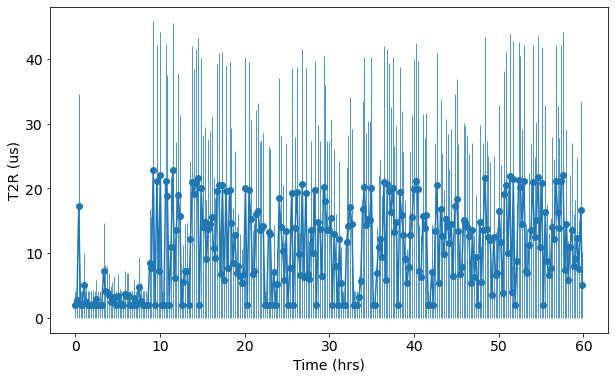

In [54]:
times = np.asarray(times)
plt.figure(figsize=(10, 6))
plt.plot(times/60/60, all_fids)
plt.xlabel('Time (hrs)')
plt.ylabel('GE fidelity')
plt.show()

plt.figure(figsize=(10, 6))
plt.errorbar(times/60/60, all_T2R, fmt='o-', yerr=all_T2R, color='tab:blue', elinewidth=0.75)
plt.xlabel('Time (hrs)')
plt.ylabel('T2R (us)')
plt.show()